# Natality project: predictive analysis 


## 1. Load and prepare the data
The dataset underwent the following changes:
- We removed the variables not used for prediction, and missing values for the dependent variable
- Categorical variables were dummified
- Numeric variables mistakenly saved as floats were changed to integers
- Interval since last pregnancy was log transformed then split in bins to be a categorical variable
- Prepregnancy weight was log transformed

In [17]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sklearn
import seaborn as sns
from pandas_profiling import ProfileReport
import statsmodels as sm
from sklearn.model_selection import GridSearchCV 
%matplotlib inline

In [62]:
# Load dataset
data = pd.read_csv('data/df_42_imputed.csv', index_col=0)
data.head()

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,birth_month,birth_time,birth_weekday,birth_place,mother_age,mother_nativity,mother_race,mother_hispanic,paternity_acknowledged,mother_education,...,no_maternal_morbidity,payment,plural_birth,sex,gestation_week,obstetric_estimate,birth_weight,no_abnormal_condition,no_congenital_anomalies,breastfed
1,1,1227.0,2,1,30,1,1,0,X,6,...,1,2,1,M,38.0,40.0,3657.0,1,1,Y
2,1,336.0,2,1,28,1,1,0,X,6,...,1,4,1,M,37.0,36.0,3470.0,1,1,Y
3,1,938.0,2,1,23,1,3,0,Y,2,...,1,1,1,F,31.0,39.0,3140.0,1,1,N
4,1,28.0,2,2,26,1,1,0,X,6,...,1,2,1,F,40.0,39.0,4082.0,1,1,Y
5,1,1615.0,4,1,31,1,1,0,X,3,...,1,2,1,F,40.0,40.0,3230.0,1,1,Y


In [63]:
#Remove columns not used for prediction:  
data.drop(['induction', 'father_age','BMI','birth_weekday','number_prenatal_visits', 'delivery_method', 'breastfed', 
           'no_abnormal_condition', 'no_maternal_morbidity', 'birth_weight', 'birth_time', 'delivery_weight', 
           'labor_trial', 'no_congenital_anomalies', 'gestation_week'], inplace=True, axis =1)
data.shape

(1921127, 27)

In [64]:
categorical = ['birth_month', 'birth_place', 'mother_nativity', 'mother_race', 'mother_hispanic', 'paternity_acknowledged',
               'mother_education', 'father_race', 'father_hispanic', 'father_education', 'WIC', 'tobacco', 
               'previous_preterm_birth', 'infertility_treatment','no_risk_factors', 'no_infection',
                'payment', 'sex']
data[categorical] = data[categorical].astype(str)

In [65]:
#Remove missing values for the dependant variable
df_clean = data[data.obstetric_estimate.notna()].reset_index(drop=True)

In [66]:
#Check 
ProfileReport(df_clean)

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,27
Number of observations,1919518
Total Missing (%),0.0%
Total size in memory,395.4 MiB
Average record size in memory,216.0 B
Numeric,9
Categorical,18
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [67]:
# Make dummy variable for all categorical variables
for var in categorical:
    dummy = pd.get_dummies(df_clean[str(var)])
    col_dict = {}
    for i in dummy.columns:
        col_dict[i] = str(var) + "-" + str(i)
    dummy = dummy.rename(columns=col_dict)
    dummy = dummy.drop(columns=dummy.columns[0])
    df_clean = pd.concat([df_clean, dummy], axis = 1)
    df_clean = df_clean.drop(var, axis =1)
df_clean.head()

,mother_age,total_birth_order,interval_since_last_pregnancy,month_prenatal_care_began,mother_height,prepregnancy_weight,previous_cesareans,plural_birth,obstetric_estimate,birth_month-10,...,WIC-Y,tobacco-Y,previous_preterm_birth-Y,infertility_treatment-Y,no_risk_factors-1,no_infection-1,payment-2,payment-3,payment-4,sex-M
0,30,4.0,16.000000,3.0,66.0,190.0,0,1,40.0,0,...,0,0,0,0,1,1,1,0,0,1
1,28,2.0,210.034575,5.0,71.0,215.0,0,1,36.0,0,...,1,0,0,0,0,1,0,0,1,1
2,23,3.0,43.000000,5.0,64.0,138.0,0,1,39.0,0,...,0,0,0,0,1,1,0,0,0,0
3,26,2.0,39.000000,2.0,67.0,200.0,0,1,39.0,0,...,0,0,0,0,1,1,1,0,0,0
4,31,1.0,888.000000,3.0,67.0,180.0,0,1,40.0,0,...,0,0,0,0,1,1,1,0,0,0


In [68]:
#df_clean = df_clean.dropna()
numeric = ['mother_age','total_birth_order', 'month_prenatal_care_began', 'mother_height', 
           'prepregnancy_weight', 'previous_cesareans', 'plural_birth', 'obstetric_estimate' ]
for item in numeric:
    df_clean[item] = df_clean[item].astype(int)

In [69]:
df_clean.dtypes

mother_age                         int32
total_birth_order                  int32
interval_since_last_pregnancy    float64
month_prenatal_care_began          int32
mother_height                      int32
                                  ...   
no_infection-1                     uint8
payment-2                          uint8
payment-3                          uint8
payment-4                          uint8
sex-M                              uint8
Length: 79, dtype: object

Variable 'interval since last pregnancy' is coded 888 for 'no previous child'. We are going to split it into categories. We immediately create columns for dummy variables.
In addition, the distribution is skewed and we want to use the log of the interval so our categories are more balanced (normally distributed).

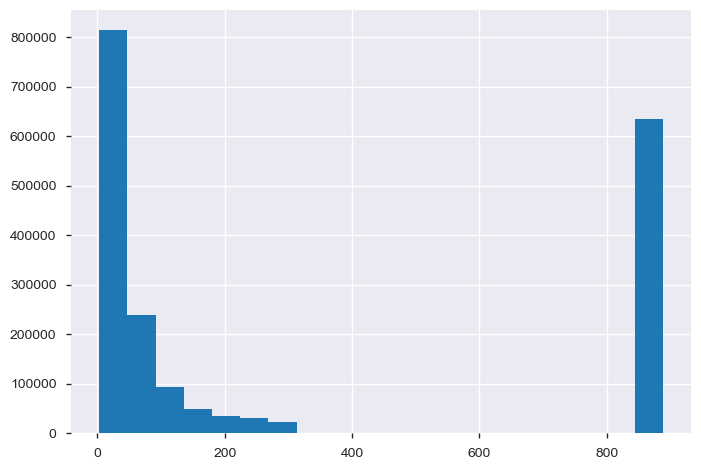

In [70]:
# Check the distribution before transforming - if we make bins now the data won't be spread into bins
plt.hist(df_clean.interval_since_last_pregnancy, 20)
plt.show()

Text(0.5, 1.0, 'Log(interval since last pregnancy) distribution is not skewed, but appears normal')

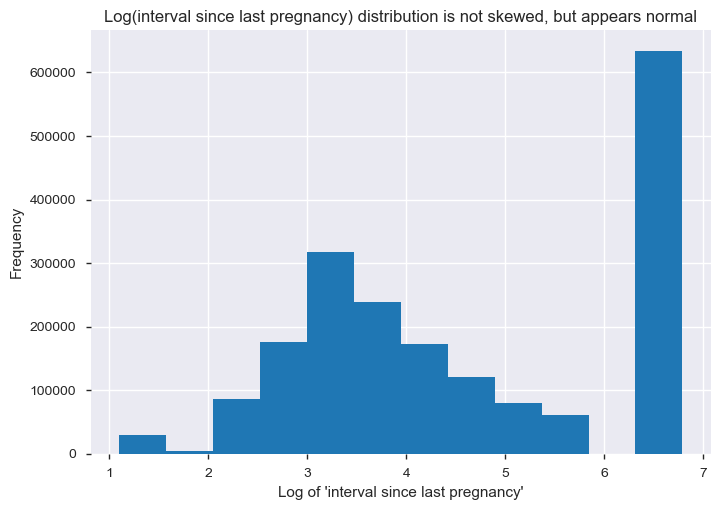

In [71]:
#Create a column with the log of the interval and check if distribution is normal
df_clean['interval_since_last_pregnancy_log'] = np.log(df_clean.interval_since_last_pregnancy)
plt.hist(df_clean.interval_since_last_pregnancy_log, 12)
plt.xlabel("Log of 'interval since last pregnancy'")
plt.ylabel("Frequency")
plt.title("Log(interval since last pregnancy) distribution is not skewed, but appears normal")

Once we take the log of the interval, the distribution is normal (data coded 888 are first time mothers, in other words cases for which interval since last pregnancy is not applicable)

In [72]:
#Use the array to split into 10 categories (from 12: for dummy variables, we need n-1 columns. Column 11 is 
#the one we remove.  Column 10 did not comatin any records)
histogram_limits = [1.09861229, 1.57280891, 2.04700553, 2.52120215, 2.99539877,
        3.46959539, 3.94379202, 4.41798864, 4.89218526, 5.36638188,
        5.8405785 , 6.31477512, 6.78897174]

for i in range(0, len(histogram_limits)-3):
    df_clean['interval-'+str(i)] = df_clean.interval_since_last_pregnancy_log.between(histogram_limits[i], histogram_limits[i+1])
        

In [73]:
# Remove unnecessary columns
df_clean.drop([ 'interval_since_last_pregnancy', 'interval_since_last_pregnancy_log'], inplace=True, axis =1)


Text(0.5, 1.0, 'Log(prepregnancy weight) distribution is not skewed, but appears normal')

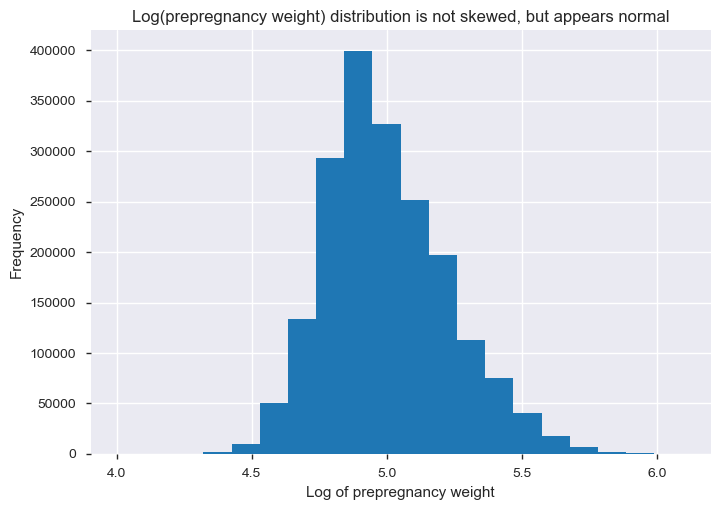

In [74]:
df_clean.prepregnancy_weight = np.log(df_clean.prepregnancy_weight)
plt.hist(df_clean.prepregnancy_weight, 20)
plt.xlabel("Log of prepregnancy weight")
plt.ylabel("Frequency")
plt.title("Log(prepregnancy weight) distribution is not skewed, but appears normal")

In [75]:
print(df_clean.dtypes)

mother_age                     int32
total_birth_order              int32
month_prenatal_care_began      int32
mother_height                  int32
prepregnancy_weight          float64
                              ...   
interval-5                      bool
interval-6                      bool
interval-7                      bool
interval-8                      bool
interval-9                      bool
Length: 88, dtype: object


In [5]:
df_clean.to_csv('data/df_dummy_var_log_transfo.csv', index=False)
#df_clean = pd.read_csv('data/df_dummy_var_log_transfo.csv')

Finally, we split the dataset into train and test sets:

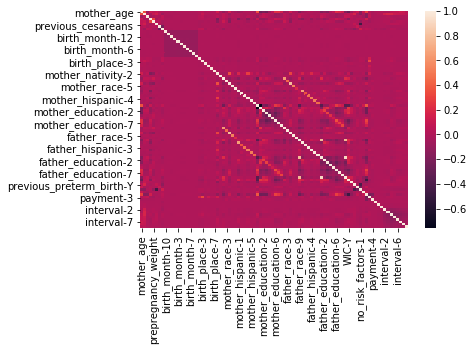

In [6]:
df_corr_matrix = df_clean.corr()
sns.heatmap(data=df_corr_matrix, annot=False)

In [15]:
correlations = abs(df_corr_matrix['obstetric_estimate']).sort_values(ascending=False)
print('50 features with the highest correlation with the obstertric estimate (in absolute values):', correlations[1:52])
print('32 features with the lowest correlation with the obstertric estimate (in absolute values):', correlations[52:])

50 features with the highest correlation with the obstertric estimate (in absolute values): plural_birth                 0.254109
no_risk_factors-1            0.144091
previous_preterm_birth-Y     0.130654
mother_race-2                0.082127
father_education-9           0.076021
father_hispanic-9            0.075123
paternity_acknowledged-X     0.074800
birth_place-3                0.071168
father_race-9                0.068010
month_prenatal_care_began    0.066856
total_birth_order            0.065787
tobacco-Y                    0.065075
father_education-6           0.054709
mother_education-6           0.054541
birth_place-2                0.053593
payment-2                    0.052124
father_race-2                0.048049
mother_height                0.047173
mother_education-3           0.042487
interval-2                   0.040797
infertility_treatment-Y      0.040164
mother_education-2           0.039148
mother_education-7           0.038719
previous_cesareans           0.038

In [16]:
# Split the data set into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X = df_clean.drop(['obstetric_estimate'], axis = 1)
y = df_clean.obstetric_estimate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 2)

## 2. Linear regressions

### Scikit-learn Linear Regression - OLS###

In [18]:
# Create a LinearRegression object
lm = LinearRegression(n_jobs = 6)

In [19]:
# Fit the model
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=6, normalize=False)

In [21]:
# Make predictions on test data
predictions = lm.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.15 weeks.
Percent of correct predictions: 31.0 %.
Accuracy: 96.79 %.


In [22]:
# Intercept and R^2
print('Estimated intercept coefficient: {}'.format(round(lm.intercept_), 4))
R2train = lm.score(X_train, y_train)
print('R2 train is :', round(R2train, 4))
R2test = lm.score(X_test, y_test)
print('R2 test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

Estimated intercept coefficient: 40.0
R2 train is : 0.1211
R2 test is : 0.1238
Adjusted R2 is : 0.1211


The intercept indicates that 40 weeks (out of roughly 40) are explained by a constant rather than our variables. This indicates that a linear model might not be suitable for this dataset. $R^2$ is terrible as well, just 12\% better than a random distribution.

Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week (test set)')

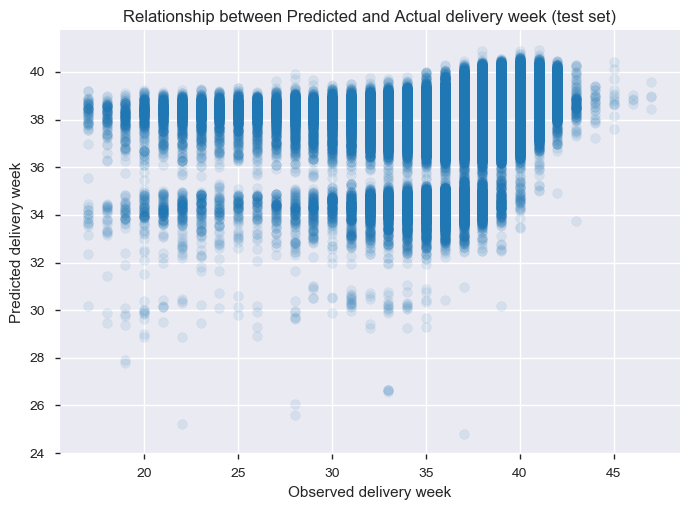

In [23]:
# Plot observed vs predicted delivery week (test set)
plt.scatter(y_test, lm.predict(X_test), alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week (test set)")

This plot indicates that there are a lot of wrong predictions for premature babies: most of the predicted values are around 34 or 36 weeks where the birth occured anywhere between 18 and 45 weeks!
This model is terrible at predicting delivery week.
Although the average absolute error is not too high, and the accuracy appears to be good, the way they are calculated doesn't give a representative idea of how good the model is. More on this later.

In [24]:
#Pearson coefficient
ols_pearsonr = stats.pearsonr(y_test, predictions)[0]
print("Pearson coefficient is:", round(ols_pearsonr, 3))

Pearson coefficient is: 0.352


Text(0.5, 1.0, 'Relationship between $\\hatY$ and the residuals')

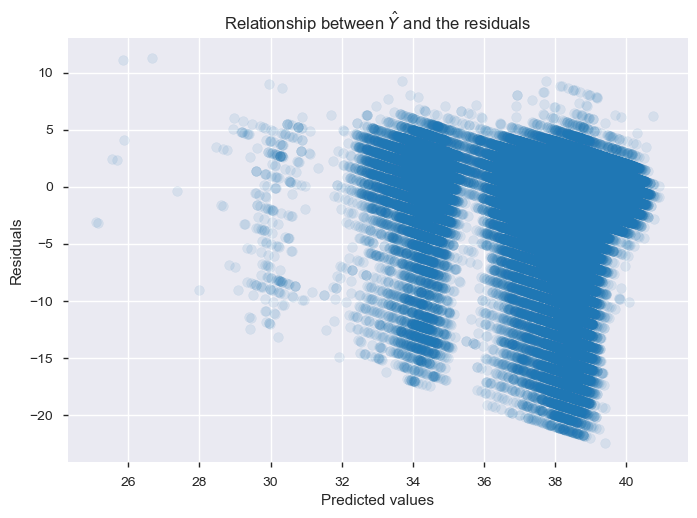

In [25]:
#Distribution of the residuals
plt.scatter(lm.predict(X_train), (y_train - lm.predict(X_train)), alpha = 0.1)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Relationship between $\hatY$ and the residuals")

There should be no pattern when plotting the fitted values vs. residuals, and there are three clusters (at 30, 34 and 36 weeks as already observed in the previous plot).
In addition, we observe more extreme residuals in the negative values (bottom half, below Residuals = 0), indicating that the model often predicts too high of a value. 

### Ridge regression###

In [28]:
from sklearn.linear_model import Ridge

# Creates a Ridge object
rm = Ridge()
# Train the model
rm.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [29]:
# Make predictions on test data
predictions = rm.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.15 weeks.
Standard deviation of absolute error: 1.54 weeks.
Percent of correct predictions: 31.0 %.
Accuracy: 96.79 %.


Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week')

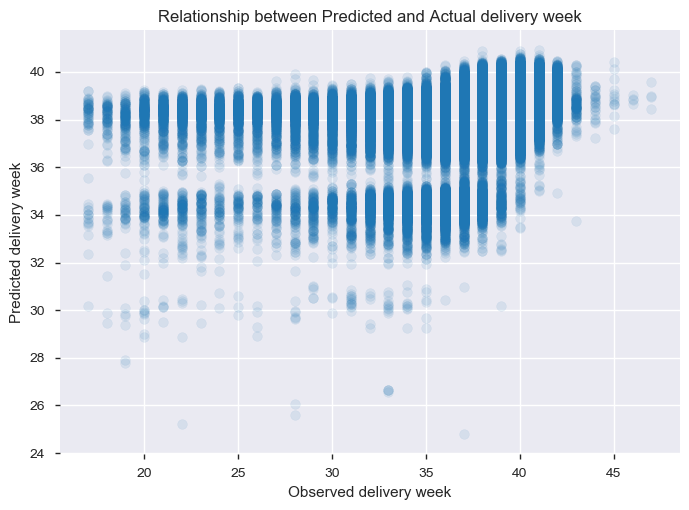

In [30]:
# Plot observed vs predicted delivery week
plt.scatter(y_test, predictions, alpha =0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week")

In [76]:
# The intercept and R2
print('Estimated intercept coefficient: {}'.format(round(rm.intercept_), 4))
R2train = rm.score(X_train, y_train)
print('R2 train is :', round(R2train, 4))
R2test = rm.score(X_test, y_test)
print('R2 test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

Estimated intercept coefficient: 40.0
R2 train is : 0.1211
R2 test is : 0.1238
Adjusted R2 is : 0.1211


This $R^2$ score is the same as the OLS regression

In [32]:
#Pearson coefficient (indicates correlation)
ridge_pearsonr = stats.pearsonr(y_test, predictions)[0]
print("Pearson coefficient is:", round(ridge_pearsonr, 4))

Pearson coefficient is: 0.3519


Text(0.5, 1.0, 'Relationship between $\\hatY$ and the residuals')

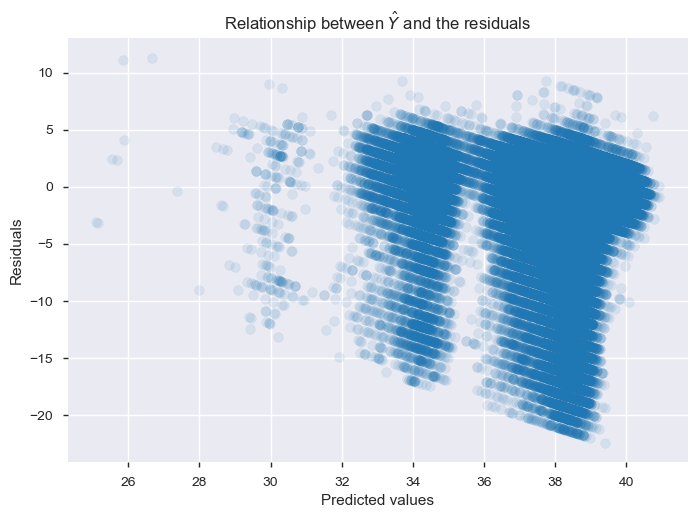

In [33]:
#Distribution of the residuals
plt.scatter(rm.predict(X_train), (y_train - rm.predict(X_train)), alpha = 0.1)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Relationship between $\hatY$ and the residuals")

Using a standard Ridge regression did not improve the model. We can try to tune alpha

In [35]:
param_grid = {'alpha': (0.01, 0.1, 1, 10, 100)} 
clf = Ridge()
clf_cv = GridSearchCV(clf, param_grid, cv=5, verbose = 1, n_jobs = 6) 
clf_cv.fit(X_train, y_train)
clf_cv.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:   32.9s finished


{'alpha': 10}

In [36]:
# Creates a Ridge object
rm2 = Ridge(alpha = 10)
# Train the Ridge object
rm2.fit(X_train, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [77]:
# The intercept and R2
print('Estimated intercept coefficient: {}'.format(round(rm2.intercept_), 4))
R2train = rm2.score(X_train, y_train)
print('R2 train is :', round(R2train, 4))
R2test = rm2.score(X_test, y_test)
print('R2 test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

Estimated intercept coefficient: 40.0
R2 train is : 0.1211
R2 test is : 0.1238
Adjusted R2 is : 0.1211


In [38]:
# Make predictions on test data
predictions = rm2.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.15 weeks.
Standard deviation of absolute error: 1.54 weeks.
Percent of correct predictions: 31.0 %.
Accuracy: 96.79 %.


Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week')

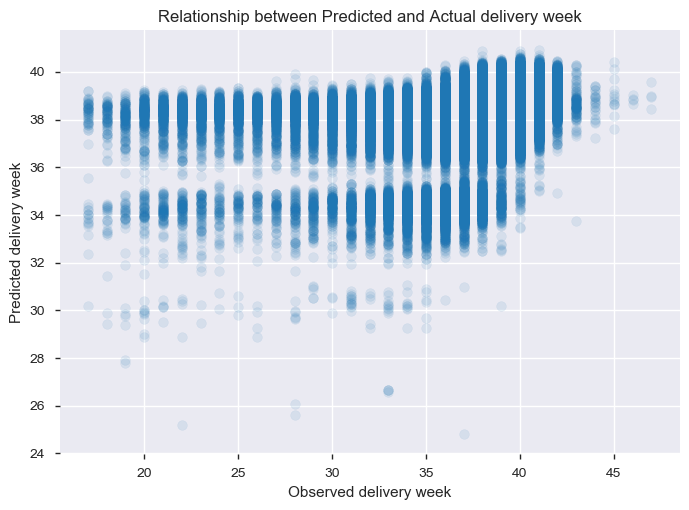

In [39]:
plt.scatter(y_test, rm2.predict(X_test), alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week")

In [40]:
# The intercept and R2
print('Estimated intercept coefficient: {}'.format(round(rm2.intercept_), 4))
R2 = rm2.score(X_test, y_test)
print('R2 is :', round(R2, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

Estimated intercept coefficient: 40.0
R2 is : 0.1238
Adjusted R2 is : 0.1238


Still no improvement, let's move to a different type of models: Support Vector Regressions

## 2. SVR ##

### With linear kernel###

Based on the documentation, for a large dataset, LinearSRV model is recommended.

In [45]:
from sklearn.svm import LinearSVR
# Create SVR object
LSVR = LinearSVR(verbose = 1)
#Train the model
LSVR.fit(X_train, y_train)

[LibLinear]

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=1)

Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week')

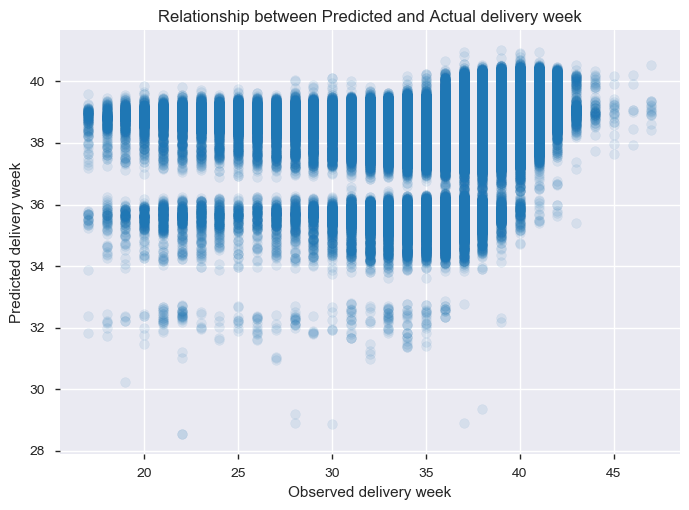

In [46]:
plt.scatter(y_train, LSVR.predict(X_train), alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week")

In [47]:
# Make predictions on test data
predictions = LSVR.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.11 weeks.
Standard deviation of absolute error: 1.62 weeks.
Percent of correct predictions: 34.0 %.
Accuracy: 96.87 %.


In [48]:
#R^2
#LSVR.score(X_test, y_test)
R2train = LSVR.score(X_train, y_train)
print('R2train is :', round(R2train, 4))
R2test = LSVR.score(X_test, y_test)
print('R2test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))



R2train is : 0.0756
R2test is : 0.0776
Adjusted R2 is : 0.0755


Based on the documentation:
The coefficient $R^2$ is defined as $$(1 - u/v)$$ where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a $R^2$ score of 0.0.

Despite this explanation, the $R^2$ value obtained does not make sense

Text(0.5, 1.0, 'Relationship between $\\hatY$ and the residuals')

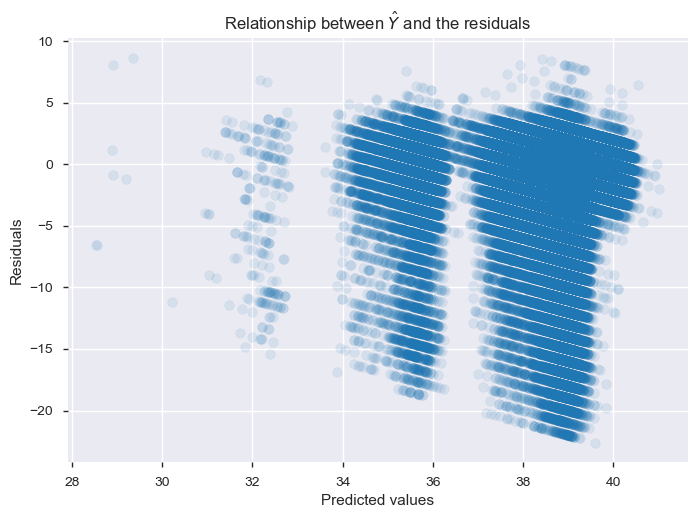

In [49]:
#Distribution of the residuals
plt.scatter(LSVR.predict(X_train), (y_train - LSVR.predict(X_train)), alpha = 0.1)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Relationship between $\hatY$ and the residuals")

SVR does not seem to be a good model either: the accuracy is lower, and $R^2$ is very similar

## 3. Random forest ##

In [18]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(verbose = 20, n_jobs = 6)
rf.fit(X_train, y_train)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100building tree 4 of 100
building tree 5 of 100

building tree 6 of 100


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   44.3s


building tree 7 of 100


[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   44.5s


building tree 8 of 100


[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   44.8s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   44.8s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   45.1s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   45.2s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.5min


building tree 13 of 100


[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.5min


building tree 14 of 100


[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.5min


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.5min


building tree 18 of 100


[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  2.3min


building tree 19 of 100


[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  2.3min


building tree 20 of 100


[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  2.3min


building tree 21 of 100


[Parallel(n_jobs=6)]: Done  16 tasks      | elapsed:  2.3min


building tree 22 of 100


[Parallel(n_jobs=6)]: Done  17 tasks      | elapsed:  2.3min


building tree 23 of 100


[Parallel(n_jobs=6)]: Done  18 tasks      | elapsed:  2.3min


building tree 24 of 100


[Parallel(n_jobs=6)]: Done  19 tasks      | elapsed:  3.1min


building tree 25 of 100


[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  3.1min


building tree 26 of 100


[Parallel(n_jobs=6)]: Done  21 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done  22 tasks      | elapsed:  3.1min


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=6)]: Done  23 tasks      | elapsed:  3.1min


building tree 29 of 100


[Parallel(n_jobs=6)]: Done  24 tasks      | elapsed:  3.1min


building tree 30 of 100


[Parallel(n_jobs=6)]: Done  25 tasks      | elapsed:  3.8min


building tree 31 of 100


[Parallel(n_jobs=6)]: Done  26 tasks      | elapsed:  3.8min


building tree 32 of 100


[Parallel(n_jobs=6)]: Done  27 tasks      | elapsed:  3.8min


building tree 33 of 100


[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  3.9min


building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=6)]: Done  30 tasks      | elapsed:  3.9min


building tree 36 of 100


[Parallel(n_jobs=6)]: Done  31 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done  32 tasks      | elapsed:  4.6min


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=6)]: Done  33 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done  34 tasks      | elapsed:  4.6min


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=6)]: Done  35 tasks      | elapsed:  4.6min


building tree 41 of 100


[Parallel(n_jobs=6)]: Done  36 tasks      | elapsed:  4.6min


building tree 42 of 100


[Parallel(n_jobs=6)]: Done  37 tasks      | elapsed:  5.4min


building tree 43 of 100


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done  39 tasks      | elapsed:  5.4min


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=6)]: Done  40 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done  41 tasks      | elapsed:  5.4min


building tree 47 of 100


[Parallel(n_jobs=6)]: Done  42 tasks      | elapsed:  5.4min


building tree 48 of 100


[Parallel(n_jobs=6)]: Done  43 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done  44 tasks      | elapsed:  6.1min


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=6)]: Done  45 tasks      | elapsed:  6.1min


building tree 51 of 100


[Parallel(n_jobs=6)]: Done  46 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done  47 tasks      | elapsed:  6.1min


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=6)]: Done  48 tasks      | elapsed:  6.2min


building tree 54 of 100


[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  6.9min


building tree 55 of 100


[Parallel(n_jobs=6)]: Done  50 tasks      | elapsed:  6.9min


building tree 56 of 100


[Parallel(n_jobs=6)]: Done  51 tasks      | elapsed:  6.9min


building tree 57 of 100


[Parallel(n_jobs=6)]: Done  52 tasks      | elapsed:  6.9min


building tree 58 of 100


[Parallel(n_jobs=6)]: Done  53 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done  54 tasks      | elapsed:  6.9min


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=6)]: Done  55 tasks      | elapsed:  7.6min


building tree 61 of 100


[Parallel(n_jobs=6)]: Done  56 tasks      | elapsed:  7.6min


building tree 62 of 100


[Parallel(n_jobs=6)]: Done  57 tasks      | elapsed:  7.7min


building tree 63 of 100


[Parallel(n_jobs=6)]: Done  58 tasks      | elapsed:  7.7min


building tree 64 of 100


[Parallel(n_jobs=6)]: Done  59 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  7.7min


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=6)]: Done  61 tasks      | elapsed:  8.4min


building tree 67 of 100


[Parallel(n_jobs=6)]: Done  62 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done  63 tasks      | elapsed:  8.4min


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:  8.4min


building tree 70 of 100


[Parallel(n_jobs=6)]: Done  65 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done  66 tasks      | elapsed:  8.4min


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=6)]: Done  67 tasks      | elapsed:  9.1min


building tree 73 of 100


[Parallel(n_jobs=6)]: Done  68 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done  69 tasks      | elapsed:  9.1min


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=6)]: Done  70 tasks      | elapsed:  9.2min


building tree 76 of 100


[Parallel(n_jobs=6)]: Done  71 tasks      | elapsed:  9.2min


building tree 77 of 100


[Parallel(n_jobs=6)]: Done  72 tasks      | elapsed:  9.2min


building tree 78 of 100


[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  9.9min


building tree 79 of 100


[Parallel(n_jobs=6)]: Done  74 tasks      | elapsed:  9.9min


building tree 80 of 100


[Parallel(n_jobs=6)]: Done  75 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done  76 tasks      | elapsed:  9.9min


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=6)]: Done  77 tasks      | elapsed:  9.9min


building tree 83 of 100


[Parallel(n_jobs=6)]: Done  78 tasks      | elapsed: 10.0min


building tree 84 of 100


[Parallel(n_jobs=6)]: Done  79 tasks      | elapsed: 10.6min


building tree 85 of 100


[Parallel(n_jobs=6)]: Done  80 tasks      | elapsed: 10.6min


building tree 86 of 100


[Parallel(n_jobs=6)]: Done  81 tasks      | elapsed: 10.7min


building tree 87 of 100


[Parallel(n_jobs=6)]: Done  82 tasks      | elapsed: 10.7min


building tree 88 of 100


[Parallel(n_jobs=6)]: Done  83 tasks      | elapsed: 10.7min


building tree 89 of 100


[Parallel(n_jobs=6)]: Done  84 tasks      | elapsed: 10.7min


building tree 90 of 100


[Parallel(n_jobs=6)]: Done  85 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed: 11.4min


building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=6)]: Done  87 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done  88 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done  89 tasks      | elapsed: 11.5min


building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=6)]: Done  95 out of 100 | elapsed: 12.2min remaining:   38.4s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed: 12.7min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=6, oob_score=False,
                      random_state=None, verbose=20, warm_start=False)

In [51]:
# Make predictions on test data
predictions = rf.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:    1.2s
[Para

Average absolute error: 1.19 weeks.
Standard deviation of absolute error: 1.53 weeks.
Percent of correct predictions: 30.0 %.
Accuracy: 96.7 %.


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    7.6s finished


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:    3.1s
[Para

Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week')

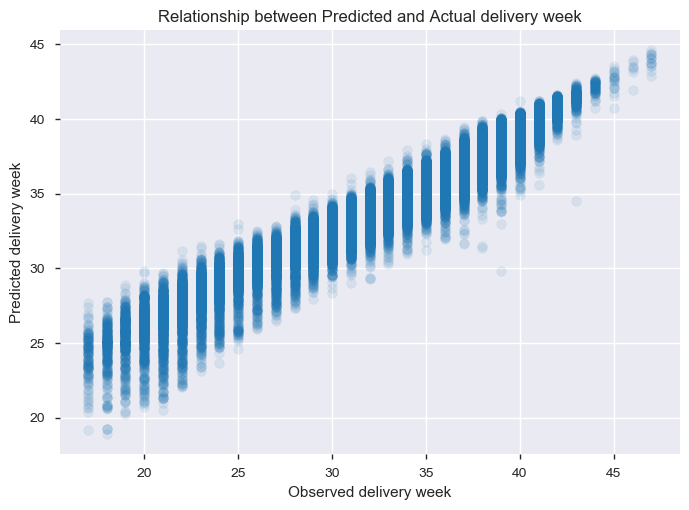

In [52]:
# Plot observed vs predicted values (train set)
plt.scatter(y_train, rf.predict(X_train), alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week")

In [53]:
# R2
R2train = rf.score(X_train, y_train)
print('R2train is :', round(R2train, 4))
R2test = rf.score(X_test, y_test)
print('R2test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:    3.1s
[Para

R2train is : 0.8739


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:    1.2s
[Para

R2test is : 0.1057
Adjusted R2 is : 0.8739


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    7.6s finished


The accuracy and error are better than previous models, but: 
$$R^2_{\text{test}}\ll R^2_{\text{training}}$$
The model does not generalize well! 

Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week (test set)')

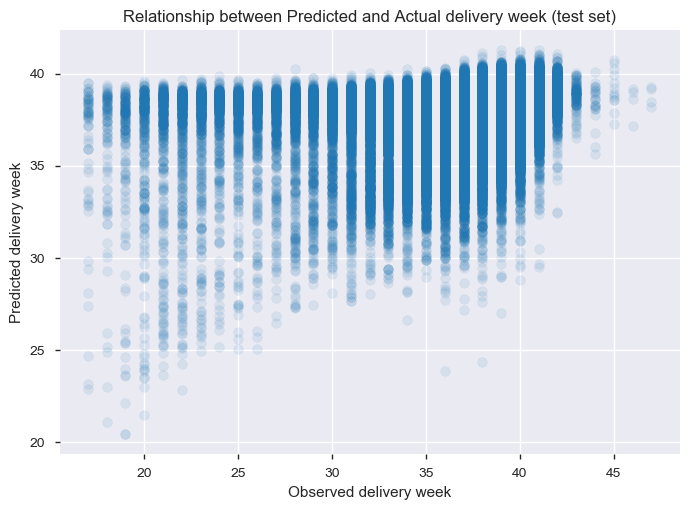

In [54]:
# Plot observed vs presdicted delivery week ON THE TEST SET
plt.scatter(y_test, predictions, alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week (test set)")

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    3.0s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:    3.1s
[Para

[Parallel(n_jobs=6)]: Done  43 tasks      | elapsed:    8.5s
[Parallel(n_jobs=6)]: Done  44 tasks      | elapsed:    8.5s
[Parallel(n_jobs=6)]: Done  45 tasks      | elapsed:    8.6s
[Parallel(n_jobs=6)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=6)]: Done  47 tasks      | elapsed:    8.6s
[Parallel(n_jobs=6)]: Done  48 tasks      | elapsed:    8.6s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:    9.6s
[Parallel(n_jobs=6)]: Done  50 tasks      | elapsed:    9.6s
[Parallel(n_jobs=6)]: Done  51 tasks      | elapsed:    9.6s
[Parallel(n_jobs=6)]: Done  52 tasks      | elapsed:    9.7s
[Parallel(n_jobs=6)]: Done  53 tasks      | elapsed:    9.7s
[Parallel(n_jobs=6)]: Done  54 tasks      | elapsed:    9.7s
[Parallel(n_jobs=6)]: Done  55 tasks      | elapsed:   10.7s
[Parallel(n_jobs=6)]: Done  56 tasks      | elapsed:   10.7s
[Parallel(n_jobs=6)]: Done  57 tasks      | elapsed:   10.7s
[Parallel(n_jobs=6)]: Done  58 tasks      | elapsed:   10.8s
[Parallel(n_jobs=6)]: Do

Text(0.5, 1.0, 'Relationship between $\\hatY$ and the residuals')

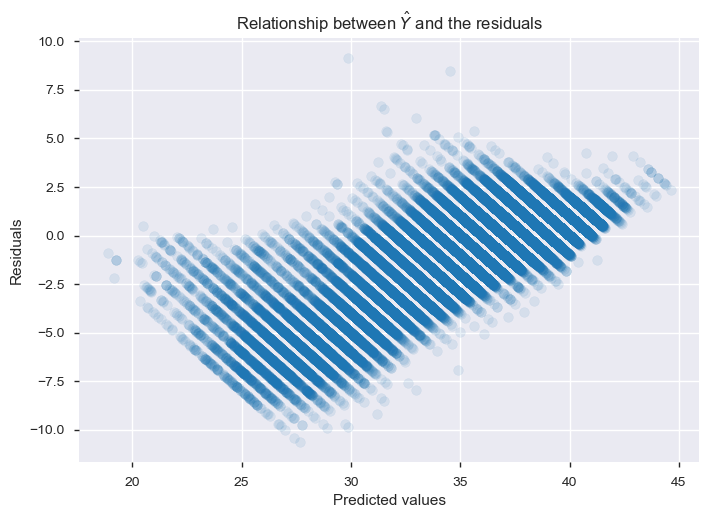

In [55]:
#Distribution of the residuals
plt.scatter(rf.predict(X_train), (y_train - rf.predict(X_train)), alpha=0.1)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Relationship between $\hatY$ and the residuals")

The code below was inspired by a blog post: https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

In [19]:
# List of features for later use
feature_list = list(df_clean.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: prepregnancy_weight  Importance: 0.144
Variable: mother_age           Importance: 0.0999
Variable: mother_height        Importance: 0.0677
Variable: plural_birth         Importance: 0.0642
Variable: total_birth_order    Importance: 0.04
Variable: month_prenatal_care_began Importance: 0.0359
Variable: infertility_treatment-Y Importance: 0.0174
Variable: no_infection-1       Importance: 0.0148
Variable: father_education-9   Importance: 0.0142
Variable: birth_month-6        Importance: 0.0132
Variable: mother_education-2   Importance: 0.0129
Variable: obstetric_estimate   Importance: 0.0127
Variable: birth_month-7        Importance: 0.0127
Variable: mother_education-3   Importance: 0.0127
Variable: birth_month-4        Importance: 0.0126
Variable: birth_month-2        Importance: 0.0125
Variable: birth_month-8        Importance: 0.0125
Variable: birth_month-5        Importance: 0.0124
Variable: birth_month-3        Importance: 0.0123
Variable: birth_month-10       Importance: 0.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

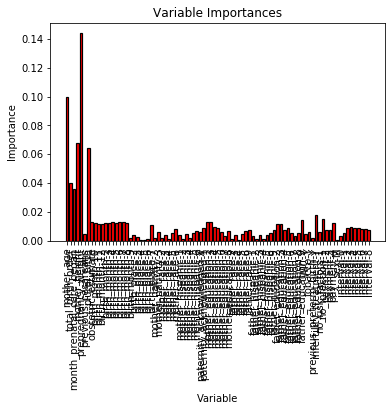

In [21]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

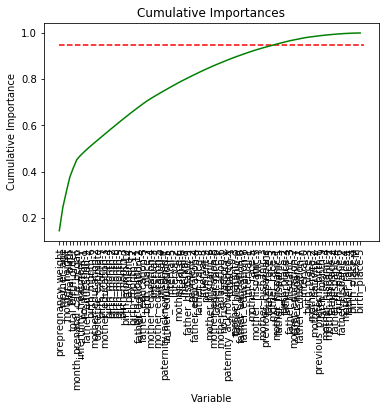

In [22]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [23]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
features95= np.where(cumulative_importances > 0.95)[0][0] + 1
print('Number of features for 95% importance:', features95)

Number of features for 95% importance: 63


In [24]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:features95]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important_X_train = X_train.iloc[:, important_indices]
important_X_test = X_test.iloc[:, important_indices]
# Sanity check on operations
print('Important train features shape:', important_X_train.shape)
print('Important test features shape:', important_X_test.shape)

Important train features shape: (1343662, 63)
Important test features shape: (575856, 63)


In [ ]:
# Create and train the expanded model on only the important features
rf2 = RandomForestRegressor()
rf2.fit(important_X_train, y_train)

In [12]:
# R2
R2train = rf2.score(important_X_train, y_train)
print('R2train is :', round(R2train, 4))
R2test = rf2.score(important_X_test, y_test)
print('R2test is :', round(R2test, 4))
n = important_X_train.shape[0]
p = important_X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

R2train is : 0.8727
R2test is : 0.1001
Adjusted R2 is : 0.8727


In [13]:
# Make predictions on test data
predictions = rf2.predict(important_X_test)
# Performance metrics
errors = abs(predictions - y_test)
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.23 weeks.
Accuracy: 96.6 %.


Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week (test set)')

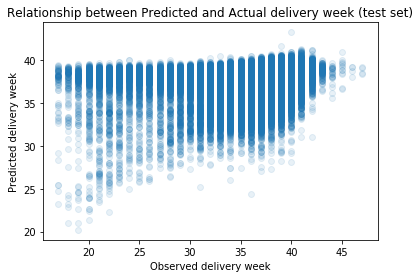

In [14]:
# Plot test set
plt.scatter(y_test, predictions, alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week (test set)")

The simplified model trains faster but is not as good, and still does not generalize well at all.
We will restrict the model more.


In [26]:
# Find number of features for cumulative importance of 70%
# Add 1 because Python is zero-indexed
features70 = np.where(cumulative_importances > 0.70)[0][0] + 1
print('Number of features for 70% importance:', features70)

Number of features for 70% importance: 26


In [27]:
# Extract the names of the most important features
important_feature_names2 = [feature[0] for feature in feature_importances[0:features70]]
# Find the columns of the most important features
important_indices2 = [feature_list.index(feature) for feature in important_feature_names2]
# Create training and testing sets with only the important features
important_X_train2 = X_train.iloc[:, important_indices2]
important_X_test2 = X_test.iloc[:, important_indices2]
# Sanity check on operations
print('Important train features shape:', important_X_train2.shape)
print('Important test features shape:', important_X_test2.shape)

Important train features shape: (1343662, 26)
Important test features shape: (575856, 26)


In [17]:
# Create and train the expanded model on only the important features
rf3 = RandomForestRegressor(verbose = 20, n_jobs = 6)
rf3.fit(important_X_train2, y_train)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100building tree 5 of 100

building tree 6 of 100


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   12.6s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   12.6s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   12.6s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   12.7s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   12.8s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   12.9s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   25.1s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   25.2s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   25.5s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   25.5s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   25.5s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   26.3s


building tree 18 of 100


[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   37.7s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:   37.8s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:   38.4s
[Parallel(n_jobs=6)]: Done  16 tasks      | elapsed:   38.4s
[Parallel(n_jobs=6)]: Done  17 tasks      | elapsed:   38.5s


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=6)]: Done  18 tasks      | elapsed:   39.0s


building tree 24 of 100


[Parallel(n_jobs=6)]: Done  19 tasks      | elapsed:   50.5s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   50.7s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=6)]: Done  21 tasks      | elapsed:   51.2s
[Parallel(n_jobs=6)]: Done  22 tasks      | elapsed:   51.4s
[Parallel(n_jobs=6)]: Done  23 tasks      | elapsed:   51.5s


building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=6)]: Done  24 tasks      | elapsed:   51.9s


building tree 30 of 100


[Parallel(n_jobs=6)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  26 tasks      | elapsed:  1.1min


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=6)]: Done  27 tasks      | elapsed:  1.1min


building tree 34 of 100


[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  30 tasks      | elapsed:  1.1min


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=6)]: Done  31 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  32 tasks      | elapsed:  1.3min


building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=6)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  35 tasks      | elapsed:  1.3min


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=6)]: Done  36 tasks      | elapsed:  1.3min


building tree 42 of 100


[Parallel(n_jobs=6)]: Done  37 tasks      | elapsed:  1.5min


building tree 43 of 100


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.5min


building tree 44 of 100


[Parallel(n_jobs=6)]: Done  39 tasks      | elapsed:  1.5min


building tree 45 of 100


[Parallel(n_jobs=6)]: Done  40 tasks      | elapsed:  1.5min


building tree 46 of 100


[Parallel(n_jobs=6)]: Done  41 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done  42 tasks      | elapsed:  1.5min


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=6)]: Done  43 tasks      | elapsed:  1.7min


building tree 49 of 100


[Parallel(n_jobs=6)]: Done  44 tasks      | elapsed:  1.7min


building tree 50 of 100


[Parallel(n_jobs=6)]: Done  45 tasks      | elapsed:  1.7min


building tree 51 of 100


[Parallel(n_jobs=6)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  47 tasks      | elapsed:  1.7min


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=6)]: Done  48 tasks      | elapsed:  1.7min


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  50 tasks      | elapsed:  1.9min


building tree 56 of 100


[Parallel(n_jobs=6)]: Done  51 tasks      | elapsed:  1.9min


building tree 57 of 100


[Parallel(n_jobs=6)]: Done  52 tasks      | elapsed:  1.9min


building tree 58 of 100


[Parallel(n_jobs=6)]: Done  53 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  54 tasks      | elapsed:  1.9min


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=6)]: Done  55 tasks      | elapsed:  2.1min


building tree 61 of 100


[Parallel(n_jobs=6)]: Done  56 tasks      | elapsed:  2.1min


building tree 62 of 100


[Parallel(n_jobs=6)]: Done  57 tasks      | elapsed:  2.1min


building tree 63 of 100


[Parallel(n_jobs=6)]: Done  58 tasks      | elapsed:  2.1min


building tree 64 of 100


[Parallel(n_jobs=6)]: Done  59 tasks      | elapsed:  2.1min


building tree 65 of 100


[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  2.2min


building tree 66 of 100


[Parallel(n_jobs=6)]: Done  61 tasks      | elapsed:  2.3min


building tree 67 of 100


[Parallel(n_jobs=6)]: Done  62 tasks      | elapsed:  2.3min


building tree 68 of 100


[Parallel(n_jobs=6)]: Done  63 tasks      | elapsed:  2.3min


building tree 69 of 100


[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done  65 tasks      | elapsed:  2.4min


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=6)]: Done  66 tasks      | elapsed:  2.4min


building tree 72 of 100


[Parallel(n_jobs=6)]: Done  67 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done  68 tasks      | elapsed:  2.5min


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=6)]: Done  69 tasks      | elapsed:  2.6min


building tree 75 of 100


[Parallel(n_jobs=6)]: Done  70 tasks      | elapsed:  2.6min


building tree 76 of 100


[Parallel(n_jobs=6)]: Done  71 tasks      | elapsed:  2.6min


building tree 77 of 100


[Parallel(n_jobs=6)]: Done  72 tasks      | elapsed:  2.6min


building tree 78 of 100


[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  2.7min


building tree 79 of 100


[Parallel(n_jobs=6)]: Done  74 tasks      | elapsed:  2.7min


building tree 80 of 100


[Parallel(n_jobs=6)]: Done  75 tasks      | elapsed:  2.8min


building tree 81 of 100


[Parallel(n_jobs=6)]: Done  76 tasks      | elapsed:  2.8min


building tree 82 of 100


[Parallel(n_jobs=6)]: Done  77 tasks      | elapsed:  2.8min


building tree 83 of 100


[Parallel(n_jobs=6)]: Done  78 tasks      | elapsed:  2.8min


building tree 84 of 100


[Parallel(n_jobs=6)]: Done  79 tasks      | elapsed:  2.9min


building tree 85 of 100


[Parallel(n_jobs=6)]: Done  80 tasks      | elapsed:  3.0min


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=6)]: Done  81 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done  82 tasks      | elapsed:  3.0min


building tree 88 of 100


[Parallel(n_jobs=6)]: Done  83 tasks      | elapsed:  3.0min


building tree 89 of 100


[Parallel(n_jobs=6)]: Done  84 tasks      | elapsed:  3.0min


building tree 90 of 100


[Parallel(n_jobs=6)]: Done  85 tasks      | elapsed:  3.2min


building tree 91 of 100


[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  3.2min


building tree 92 of 100


[Parallel(n_jobs=6)]: Done  87 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done  88 tasks      | elapsed:  3.2min


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=6)]: Done  89 tasks      | elapsed:  3.2min


building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=6)]: Done  95 out of 100 | elapsed:  3.4min remaining:   10.7s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:  3.6min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=6, oob_score=False,
                      random_state=None, verbose=20, warm_start=False)

In [20]:
# R2
R2train = rf3.score(important_X_train2, y_train)
print('R2train is :', round(R2train, 4))
R2test = rf3.score(important_X_test2, y_test)
print('R2test is :', round(R2test, 4))
n = important_X_train.shape[0]
p = important_X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:    4.2s
[Para

R2train is : 0.8608


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:    1.4s
[Para

R2test is : 0.0521
Adjusted R2 is : 0.8608


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    8.3s finished


In [21]:
# Make predictions on test data
predictions = rf3.predict(important_X_test2)
# Performance metrics
errors = abs(predictions - y_test)
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:    1.3s
[Para

Average absolute error: 1.27 weeks.
Accuracy: 96.49 %.


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    8.2s finished


95% then 70% of the features makes the model worse. Let's try and tune the parameters before moving to gradient methods

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 60, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 600, 1000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf4 = RandomForestRegressor(verbose = 20, n_jobs = 4)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf4, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=1, random_state=2, n_jobs = 4)
# Fit the random search model
rf_random.fit(important_X_train2, y_train)

In [56]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [58]:
rf4 = RandomForestRegressor(verbose = 20, n_jobs = 6, n_estimators= 1000, min_samples_split= 2,
                            min_samples_leaf= 4, max_features= 'auto', max_depth= 10, bootstrap= True )
                            
rf4.fit(important_X_train2, y_train)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    7.5s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    7.5s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    7.5s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    7.5s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    7.5s


building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000


[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   15.2s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   15.3s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   15.3s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   15.3s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   15.4s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   15.4s


building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000

[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   23.0s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:   23.0s
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:   23.1s
[Parallel(n_jobs=6)]: Done  16 tasks      | elapsed:   23.1s
[Parallel(n_jobs=6)]: Done  17 tasks      | elapsed:   23.2s



building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000


[Parallel(n_jobs=6)]: Done  18 tasks      | elapsed:   23.2s


building tree 24 of 1000


[Parallel(n_jobs=6)]: Done  19 tasks      | elapsed:   30.7s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   30.8s
[Parallel(n_jobs=6)]: Done  21 tasks      | elapsed:   30.8s


building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000


[Parallel(n_jobs=6)]: Done  22 tasks      | elapsed:   30.9s
[Parallel(n_jobs=6)]: Done  23 tasks      | elapsed:   30.9s
[Parallel(n_jobs=6)]: Done  24 tasks      | elapsed:   31.0s


building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000


[Parallel(n_jobs=6)]: Done  25 tasks      | elapsed:   38.4s
[Parallel(n_jobs=6)]: Done  26 tasks      | elapsed:   38.5s
[Parallel(n_jobs=6)]: Done  27 tasks      | elapsed:   38.5s


building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000


[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:   38.7s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   38.7s
[Parallel(n_jobs=6)]: Done  30 tasks      | elapsed:   38.8s
[Parallel(n_jobs=6)]: Done  31 tasks      | elapsed:   46.2s
[Parallel(n_jobs=6)]: Done  32 tasks      | elapsed:   46.2s
[Parallel(n_jobs=6)]: Done  33 tasks      | elapsed:   46.3s


building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000


[Parallel(n_jobs=6)]: Done  34 tasks      | elapsed:   46.5s
[Parallel(n_jobs=6)]: Done  35 tasks      | elapsed:   46.5s
[Parallel(n_jobs=6)]: Done  36 tasks      | elapsed:   46.6s


building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000


[Parallel(n_jobs=6)]: Done  37 tasks      | elapsed:   54.2s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   54.3s
[Parallel(n_jobs=6)]: Done  39 tasks      | elapsed:   54.3s


building tree 43 of 1000
building tree 44 of 1000building tree 45 of 1000



[Parallel(n_jobs=6)]: Done  40 tasks      | elapsed:   54.5s
[Parallel(n_jobs=6)]: Done  41 tasks      | elapsed:   54.5s
[Parallel(n_jobs=6)]: Done  42 tasks      | elapsed:   54.6s


building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000


[Parallel(n_jobs=6)]: Done  43 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done  44 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done  45 tasks      | elapsed:  1.0min


building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000


[Parallel(n_jobs=6)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done  47 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done  48 tasks      | elapsed:  1.0min


building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000


[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  50 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  51 tasks      | elapsed:  1.2min


building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000


[Parallel(n_jobs=6)]: Done  52 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  53 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  54 tasks      | elapsed:  1.2min


building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000


[Parallel(n_jobs=6)]: Done  55 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  57 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  58 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  59 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  1.3min


building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000


[Parallel(n_jobs=6)]: Done  61 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  62 tasks      | elapsed:  1.4min


building tree 67 of 1000
building tree 68 of 1000


[Parallel(n_jobs=6)]: Done  63 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  65 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  66 tasks      | elapsed:  1.4min


building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000


[Parallel(n_jobs=6)]: Done  67 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  69 tasks      | elapsed:  1.6min


building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000


[Parallel(n_jobs=6)]: Done  70 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  71 tasks      | elapsed:  1.6min


building tree 76 of 1000
building tree 77 of 1000


[Parallel(n_jobs=6)]: Done  72 tasks      | elapsed:  1.6min


building tree 78 of 1000


[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  74 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  75 tasks      | elapsed:  1.7min


building tree 79 of 1000building tree 80 of 1000

building tree 81 of 1000


[Parallel(n_jobs=6)]: Done  76 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  77 tasks      | elapsed:  1.7min


building tree 82 of 1000
building tree 83 of 1000


[Parallel(n_jobs=6)]: Done  78 tasks      | elapsed:  1.7min


building tree 84 of 1000


[Parallel(n_jobs=6)]: Done  79 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  80 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  81 tasks      | elapsed:  1.8min


building tree 85 of 1000
building tree 86 of 1000
building tree 87 of 1000


[Parallel(n_jobs=6)]: Done  82 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  83 tasks      | elapsed:  1.8min


building tree 88 of 1000
building tree 89 of 1000
building tree 90 of 1000


[Parallel(n_jobs=6)]: Done  84 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  85 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  87 tasks      | elapsed:  1.9min


building tree 91 of 1000
building tree 92 of 1000
building tree 93 of 1000


[Parallel(n_jobs=6)]: Done  88 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  89 tasks      | elapsed:  1.9min


building tree 94 of 1000
building tree 95 of 1000


[Parallel(n_jobs=6)]: Done  90 tasks      | elapsed:  2.0min


building tree 96 of 1000


[Parallel(n_jobs=6)]: Done  91 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done  92 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done  93 tasks      | elapsed:  2.1min


building tree 97 of 1000
building tree 98 of 1000
building tree 99 of 1000


[Parallel(n_jobs=6)]: Done  94 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done  95 tasks      | elapsed:  2.1min


building tree 100 of 1000
building tree 101 of 1000


[Parallel(n_jobs=6)]: Done  96 tasks      | elapsed:  2.1min


building tree 102 of 1000


[Parallel(n_jobs=6)]: Done  97 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  98 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  99 tasks      | elapsed:  2.2min


building tree 103 of 1000
building tree 104 of 1000
building tree 105 of 1000


[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  2.2min


building tree 106 of 1000
building tree 107 of 1000


[Parallel(n_jobs=6)]: Done 102 tasks      | elapsed:  2.2min


building tree 108 of 1000


[Parallel(n_jobs=6)]: Done 103 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 104 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 105 tasks      | elapsed:  2.3min


building tree 109 of 1000
building tree 110 of 1000
building tree 111 of 1000


[Parallel(n_jobs=6)]: Done 106 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 107 tasks      | elapsed:  2.3min


building tree 112 of 1000
building tree 113 of 1000


[Parallel(n_jobs=6)]: Done 108 tasks      | elapsed:  2.4min


building tree 114 of 1000


[Parallel(n_jobs=6)]: Done 109 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 110 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 111 tasks      | elapsed:  2.5min


building tree 115 of 1000
building tree 116 of 1000
building tree 117 of 1000


[Parallel(n_jobs=6)]: Done 112 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 113 tasks      | elapsed:  2.5min


building tree 118 of 1000
building tree 119 of 1000


[Parallel(n_jobs=6)]: Done 114 tasks      | elapsed:  2.5min


building tree 120 of 1000


[Parallel(n_jobs=6)]: Done 115 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 117 tasks      | elapsed:  2.6min


building tree 121 of 1000building tree 122 of 1000building tree 123 of 1000




[Parallel(n_jobs=6)]: Done 118 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 119 tasks      | elapsed:  2.6min


building tree 124 of 1000
building tree 125 of 1000


[Parallel(n_jobs=6)]: Done 120 tasks      | elapsed:  2.6min


building tree 126 of 1000


[Parallel(n_jobs=6)]: Done 121 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 122 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 123 tasks      | elapsed:  2.7min


building tree 127 of 1000
building tree 128 of 1000building tree 129 of 1000



[Parallel(n_jobs=6)]: Done 124 tasks      | elapsed:  2.7min


building tree 130 of 1000


[Parallel(n_jobs=6)]: Done 125 tasks      | elapsed:  2.7min


building tree 131 of 1000


[Parallel(n_jobs=6)]: Done 126 tasks      | elapsed:  2.8min


building tree 132 of 1000


[Parallel(n_jobs=6)]: Done 127 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 128 tasks      | elapsed:  2.8min


building tree 133 of 1000
building tree 134 of 1000


[Parallel(n_jobs=6)]: Done 129 tasks      | elapsed:  2.8min


building tree 135 of 1000


[Parallel(n_jobs=6)]: Done 130 tasks      | elapsed:  2.9min


building tree 136 of 1000


[Parallel(n_jobs=6)]: Done 131 tasks      | elapsed:  2.9min


building tree 137 of 1000


[Parallel(n_jobs=6)]: Done 132 tasks      | elapsed:  2.9min


building tree 138 of 1000


[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 134 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 135 tasks      | elapsed:  3.0min


building tree 139 of 1000
building tree 140 of 1000
building tree 141 of 1000


[Parallel(n_jobs=6)]: Done 136 tasks      | elapsed:  3.0min


building tree 142 of 1000


[Parallel(n_jobs=6)]: Done 137 tasks      | elapsed:  3.0min


building tree 143 of 1000


[Parallel(n_jobs=6)]: Done 138 tasks      | elapsed:  3.0min


building tree 144 of 1000


[Parallel(n_jobs=6)]: Done 139 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 140 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed:  3.1min


building tree 145 of 1000
building tree 146 of 1000
building tree 147 of 1000


[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed:  3.1min


building tree 148 of 1000


[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed:  3.1min


building tree 149 of 1000


[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed:  3.1min


building tree 150 of 1000


[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed:  3.2min


building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000


[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed:  3.3min


building tree 154 of 1000


[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed:  3.3min


building tree 155 of 1000


[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  3.3min


building tree 156 of 1000


[Parallel(n_jobs=6)]: Done 151 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 152 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 153 tasks      | elapsed:  3.4min


building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000


[Parallel(n_jobs=6)]: Done 154 tasks      | elapsed:  3.4min


building tree 160 of 1000


[Parallel(n_jobs=6)]: Done 155 tasks      | elapsed:  3.4min


building tree 161 of 1000


[Parallel(n_jobs=6)]: Done 156 tasks      | elapsed:  3.4min


building tree 162 of 1000


[Parallel(n_jobs=6)]: Done 157 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 158 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 159 tasks      | elapsed:  3.5min


building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000


[Parallel(n_jobs=6)]: Done 160 tasks      | elapsed:  3.5min


building tree 166 of 1000


[Parallel(n_jobs=6)]: Done 161 tasks      | elapsed:  3.5min


building tree 167 of 1000


[Parallel(n_jobs=6)]: Done 162 tasks      | elapsed:  3.5min


building tree 168 of 1000


[Parallel(n_jobs=6)]: Done 163 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 164 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 165 tasks      | elapsed:  3.6min


building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000


[Parallel(n_jobs=6)]: Done 166 tasks      | elapsed:  3.6min


building tree 172 of 1000


[Parallel(n_jobs=6)]: Done 167 tasks      | elapsed:  3.6min


building tree 173 of 1000


[Parallel(n_jobs=6)]: Done 168 tasks      | elapsed:  3.7min


building tree 174 of 1000


[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 170 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 171 tasks      | elapsed:  3.8min


building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000


[Parallel(n_jobs=6)]: Done 172 tasks      | elapsed:  3.8min


building tree 178 of 1000


[Parallel(n_jobs=6)]: Done 173 tasks      | elapsed:  3.8min


building tree 179 of 1000


[Parallel(n_jobs=6)]: Done 174 tasks      | elapsed:  3.8min


building tree 180 of 1000


[Parallel(n_jobs=6)]: Done 175 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 176 tasks      | elapsed:  3.9min


building tree 181 of 1000
building tree 182 of 1000


[Parallel(n_jobs=6)]: Done 177 tasks      | elapsed:  3.9min


building tree 183 of 1000


[Parallel(n_jobs=6)]: Done 178 tasks      | elapsed:  3.9min


building tree 184 of 1000


[Parallel(n_jobs=6)]: Done 179 tasks      | elapsed:  3.9min


building tree 185 of 1000
building tree 186 of 1000


[Parallel(n_jobs=6)]: Done 180 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 181 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 182 tasks      | elapsed:  4.0min


building tree 187 of 1000
building tree 188 of 1000


[Parallel(n_jobs=6)]: Done 183 tasks      | elapsed:  4.0min


building tree 189 of 1000


[Parallel(n_jobs=6)]: Done 184 tasks      | elapsed:  4.0min


building tree 190 of 1000


[Parallel(n_jobs=6)]: Done 185 tasks      | elapsed:  4.0min


building tree 191 of 1000


[Parallel(n_jobs=6)]: Done 186 tasks      | elapsed:  4.0min


building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000

[Parallel(n_jobs=6)]: Done 187 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 189 tasks      | elapsed:  4.1min


[Parallel(n_jobs=6)]: Done 190 tasks      | elapsed:  4.1min


building tree 196 of 1000


[Parallel(n_jobs=6)]: Done 191 tasks      | elapsed:  4.2min


building tree 197 of 1000


[Parallel(n_jobs=6)]: Done 192 tasks      | elapsed:  4.2min


building tree 198 of 1000


[Parallel(n_jobs=6)]: Done 193 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 194 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 195 tasks      | elapsed:  4.3min


building tree 199 of 1000
building tree 200 of 1000
building tree 201 of 1000


[Parallel(n_jobs=6)]: Done 196 tasks      | elapsed:  4.3min


building tree 202 of 1000


[Parallel(n_jobs=6)]: Done 197 tasks      | elapsed:  4.3min


building tree 203 of 1000


[Parallel(n_jobs=6)]: Done 198 tasks      | elapsed:  4.3min


building tree 204 of 1000


[Parallel(n_jobs=6)]: Done 199 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 200 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 201 tasks      | elapsed:  4.4min


building tree 205 of 1000
building tree 206 of 1000
building tree 207 of 1000


[Parallel(n_jobs=6)]: Done 202 tasks      | elapsed:  4.4min


building tree 208 of 1000


[Parallel(n_jobs=6)]: Done 203 tasks      | elapsed:  4.4min


building tree 209 of 1000


[Parallel(n_jobs=6)]: Done 204 tasks      | elapsed:  4.4min


building tree 210 of 1000


[Parallel(n_jobs=6)]: Done 205 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 206 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 207 tasks      | elapsed:  4.5min


building tree 211 of 1000
building tree 212 of 1000
building tree 213 of 1000


[Parallel(n_jobs=6)]: Done 208 tasks      | elapsed:  4.5min


building tree 214 of 1000


[Parallel(n_jobs=6)]: Done 209 tasks      | elapsed:  4.5min


building tree 215 of 1000


[Parallel(n_jobs=6)]: Done 210 tasks      | elapsed:  4.6min


building tree 216 of 1000


[Parallel(n_jobs=6)]: Done 211 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 212 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 213 tasks      | elapsed:  4.6min


building tree 217 of 1000
building tree 218 of 1000
building tree 219 of 1000


[Parallel(n_jobs=6)]: Done 214 tasks      | elapsed:  4.7min


building tree 220 of 1000


[Parallel(n_jobs=6)]: Done 215 tasks      | elapsed:  4.7min


building tree 221 of 1000


[Parallel(n_jobs=6)]: Done 216 tasks      | elapsed:  4.7min


building tree 222 of 1000


[Parallel(n_jobs=6)]: Done 217 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 218 tasks      | elapsed:  4.8min


building tree 223 of 1000
building tree 224 of 1000


[Parallel(n_jobs=6)]: Done 219 tasks      | elapsed:  4.8min


building tree 225 of 1000


[Parallel(n_jobs=6)]: Done 220 tasks      | elapsed:  4.8min


building tree 226 of 1000


[Parallel(n_jobs=6)]: Done 221 tasks      | elapsed:  4.8min


building tree 227 of 1000


[Parallel(n_jobs=6)]: Done 222 tasks      | elapsed:  4.8min


building tree 228 of 1000


[Parallel(n_jobs=6)]: Done 223 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 224 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 225 tasks      | elapsed:  4.9min


building tree 229 of 1000
building tree 230 of 1000
building tree 231 of 1000

[Parallel(n_jobs=6)]: Done 226 tasks      | elapsed:  4.9min



building tree 232 of 1000


[Parallel(n_jobs=6)]: Done 227 tasks      | elapsed:  4.9min


building tree 233 of 1000


[Parallel(n_jobs=6)]: Done 228 tasks      | elapsed:  4.9min


building tree 234 of 1000


[Parallel(n_jobs=6)]: Done 229 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 230 tasks      | elapsed:  5.0min


building tree 235 of 1000
building tree 236 of 1000


[Parallel(n_jobs=6)]: Done 231 tasks      | elapsed:  5.0min


building tree 237 of 1000


[Parallel(n_jobs=6)]: Done 232 tasks      | elapsed:  5.0min


building tree 238 of 1000


[Parallel(n_jobs=6)]: Done 233 tasks      | elapsed:  5.0min


building tree 239 of 1000


[Parallel(n_jobs=6)]: Done 234 tasks      | elapsed:  5.1min


building tree 240 of 1000


[Parallel(n_jobs=6)]: Done 235 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 236 tasks      | elapsed:  5.2min


building tree 241 of 1000
building tree 242 of 1000


[Parallel(n_jobs=6)]: Done 237 tasks      | elapsed:  5.2min


building tree 243 of 1000


[Parallel(n_jobs=6)]: Done 238 tasks      | elapsed:  5.2min


building tree 244 of 1000


[Parallel(n_jobs=6)]: Done 239 tasks      | elapsed:  5.2min


building tree 245 of 1000


[Parallel(n_jobs=6)]: Done 240 tasks      | elapsed:  5.2min


building tree 246 of 1000


[Parallel(n_jobs=6)]: Done 241 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 242 tasks      | elapsed:  5.3min


building tree 247 of 1000
building tree 248 of 1000


[Parallel(n_jobs=6)]: Done 243 tasks      | elapsed:  5.3min


building tree 249 of 1000


[Parallel(n_jobs=6)]: Done 244 tasks      | elapsed:  5.3min


building tree 250 of 1000


[Parallel(n_jobs=6)]: Done 245 tasks      | elapsed:  5.3min


building tree 251 of 1000


[Parallel(n_jobs=6)]: Done 246 tasks      | elapsed:  5.3min


building tree 252 of 1000


[Parallel(n_jobs=6)]: Done 247 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 248 tasks      | elapsed:  5.4min


building tree 253 of 1000
building tree 254 of 1000


[Parallel(n_jobs=6)]: Done 249 tasks      | elapsed:  5.4min


building tree 255 of 1000
building tree 256 of 1000


[Parallel(n_jobs=6)]: Done 250 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 251 tasks      | elapsed:  5.4min


building tree 257 of 1000


[Parallel(n_jobs=6)]: Done 252 tasks      | elapsed:  5.5min


building tree 258 of 1000


[Parallel(n_jobs=6)]: Done 253 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 254 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 255 tasks      | elapsed:  5.5min


building tree 259 of 1000
building tree 260 of 1000
building tree 261 of 1000


[Parallel(n_jobs=6)]: Done 256 tasks      | elapsed:  5.6min


building tree 262 of 1000


[Parallel(n_jobs=6)]: Done 257 tasks      | elapsed:  5.6min


building tree 263 of 1000


[Parallel(n_jobs=6)]: Done 258 tasks      | elapsed:  5.6min


building tree 264 of 1000


[Parallel(n_jobs=6)]: Done 259 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 260 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 261 tasks      | elapsed:  5.7min


building tree 265 of 1000
building tree 266 of 1000
building tree 267 of 1000


[Parallel(n_jobs=6)]: Done 262 tasks      | elapsed:  5.7min


building tree 268 of 1000


[Parallel(n_jobs=6)]: Done 263 tasks      | elapsed:  5.7min


building tree 269 of 1000


[Parallel(n_jobs=6)]: Done 264 tasks      | elapsed:  5.7min


building tree 270 of 1000


[Parallel(n_jobs=6)]: Done 265 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 266 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 267 tasks      | elapsed:  5.8min


building tree 271 of 1000
building tree 272 of 1000
building tree 273 of 1000


[Parallel(n_jobs=6)]: Done 268 tasks      | elapsed:  5.8min


building tree 274 of 1000


[Parallel(n_jobs=6)]: Done 269 tasks      | elapsed:  5.8min


building tree 275 of 1000


[Parallel(n_jobs=6)]: Done 270 tasks      | elapsed:  5.9min


building tree 276 of 1000


[Parallel(n_jobs=6)]: Done 271 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 272 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 273 tasks      | elapsed:  5.9min


building tree 277 of 1000
building tree 278 of 1000
building tree 279 of 1000


[Parallel(n_jobs=6)]: Done 274 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 275 tasks      | elapsed:  5.9min


building tree 280 of 1000
building tree 281 of 1000


[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  6.0min


building tree 282 of 1000


[Parallel(n_jobs=6)]: Done 277 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 278 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 279 tasks      | elapsed:  6.1min


building tree 283 of 1000
building tree 284 of 1000
building tree 285 of 1000


[Parallel(n_jobs=6)]: Done 280 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 281 tasks      | elapsed:  6.1min


building tree 286 of 1000
building tree 287 of 1000


[Parallel(n_jobs=6)]: Done 282 tasks      | elapsed:  6.1min


building tree 288 of 1000


[Parallel(n_jobs=6)]: Done 283 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 284 tasks      | elapsed:  6.2min


building tree 289 of 1000
building tree 290 of 1000


[Parallel(n_jobs=6)]: Done 285 tasks      | elapsed:  6.2min


building tree 291 of 1000


[Parallel(n_jobs=6)]: Done 286 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 287 tasks      | elapsed:  6.2min


building tree 292 of 1000
building tree 293 of 1000


[Parallel(n_jobs=6)]: Done 288 tasks      | elapsed:  6.2min


building tree 294 of 1000


[Parallel(n_jobs=6)]: Done 289 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 290 tasks      | elapsed:  6.3min


building tree 295 of 1000
building tree 296 of 1000


[Parallel(n_jobs=6)]: Done 291 tasks      | elapsed:  6.3min


building tree 297 of 1000


[Parallel(n_jobs=6)]: Done 292 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 293 tasks      | elapsed:  6.3min


building tree 298 of 1000
building tree 299 of 1000


[Parallel(n_jobs=6)]: Done 294 tasks      | elapsed:  6.4min


building tree 300 of 1000


[Parallel(n_jobs=6)]: Done 295 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 296 tasks      | elapsed:  6.4min


building tree 301 of 1000
building tree 302 of 1000


[Parallel(n_jobs=6)]: Done 297 tasks      | elapsed:  6.4min


building tree 303 of 1000


[Parallel(n_jobs=6)]: Done 298 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 299 tasks      | elapsed:  6.5min


building tree 304 of 1000
building tree 305 of 1000


[Parallel(n_jobs=6)]: Done 300 tasks      | elapsed:  6.5min


building tree 306 of 1000


[Parallel(n_jobs=6)]: Done 301 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 302 tasks      | elapsed:  6.6min


building tree 307 of 1000
building tree 308 of 1000


[Parallel(n_jobs=6)]: Done 303 tasks      | elapsed:  6.6min


building tree 309 of 1000


[Parallel(n_jobs=6)]: Done 304 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 305 tasks      | elapsed:  6.6min


building tree 310 of 1000
building tree 311 of 1000


[Parallel(n_jobs=6)]: Done 306 tasks      | elapsed:  6.6min


building tree 312 of 1000


[Parallel(n_jobs=6)]: Done 307 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 308 tasks      | elapsed:  6.7min


building tree 313 of 1000
building tree 314 of 1000


[Parallel(n_jobs=6)]: Done 309 tasks      | elapsed:  6.7min


building tree 315 of 1000


[Parallel(n_jobs=6)]: Done 310 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 311 tasks      | elapsed:  6.7min


building tree 316 of 1000building tree 317 of 1000



[Parallel(n_jobs=6)]: Done 312 tasks      | elapsed:  6.7min


building tree 318 of 1000


[Parallel(n_jobs=6)]: Done 313 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 314 tasks      | elapsed:  6.8min


building tree 319 of 1000
building tree 320 of 1000


[Parallel(n_jobs=6)]: Done 315 tasks      | elapsed:  6.8min


building tree 321 of 1000


[Parallel(n_jobs=6)]: Done 316 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 317 tasks      | elapsed:  6.8min


building tree 322 of 1000
building tree 323 of 1000


[Parallel(n_jobs=6)]: Done 318 tasks      | elapsed:  6.9min


building tree 324 of 1000


[Parallel(n_jobs=6)]: Done 319 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 320 tasks      | elapsed:  7.0min


building tree 325 of 1000
building tree 326 of 1000


[Parallel(n_jobs=6)]: Done 321 tasks      | elapsed:  7.0min


building tree 327 of 1000


[Parallel(n_jobs=6)]: Done 322 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 323 tasks      | elapsed:  7.0min


building tree 328 of 1000
building tree 329 of 1000


[Parallel(n_jobs=6)]: Done 324 tasks      | elapsed:  7.0min


building tree 330 of 1000


[Parallel(n_jobs=6)]: Done 325 tasks      | elapsed:  7.1min


building tree 331 of 1000


[Parallel(n_jobs=6)]: Done 326 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 327 tasks      | elapsed:  7.1min


building tree 332 of 1000
building tree 333 of 1000


[Parallel(n_jobs=6)]: Done 328 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 329 tasks      | elapsed:  7.1min


building tree 334 of 1000
building tree 335 of 1000


[Parallel(n_jobs=6)]: Done 330 tasks      | elapsed:  7.1min


building tree 336 of 1000
building tree 337 of 1000


[Parallel(n_jobs=6)]: Done 331 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 332 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 333 tasks      | elapsed:  7.2min


building tree 338 of 1000
building tree 339 of 1000


[Parallel(n_jobs=6)]: Done 334 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 335 tasks      | elapsed:  7.2min


building tree 340 of 1000
building tree 341 of 1000


[Parallel(n_jobs=6)]: Done 336 tasks      | elapsed:  7.3min


building tree 342 of 1000


[Parallel(n_jobs=6)]: Done 337 tasks      | elapsed:  7.3min


building tree 343 of 1000


[Parallel(n_jobs=6)]: Done 338 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 339 tasks      | elapsed:  7.3min


building tree 344 of 1000
building tree 345 of 1000


[Parallel(n_jobs=6)]: Done 340 tasks      | elapsed:  7.4min


building tree 346 of 1000
building tree 347 of 1000


[Parallel(n_jobs=6)]: Done 341 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 342 tasks      | elapsed:  7.4min


building tree 348 of 1000


[Parallel(n_jobs=6)]: Done 343 tasks      | elapsed:  7.5min


building tree 349 of 1000


[Parallel(n_jobs=6)]: Done 344 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 345 tasks      | elapsed:  7.5min


building tree 350 of 1000
building tree 351 of 1000


[Parallel(n_jobs=6)]: Done 346 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 347 tasks      | elapsed:  7.5min


building tree 352 of 1000
building tree 353 of 1000


[Parallel(n_jobs=6)]: Done 348 tasks      | elapsed:  7.5min


building tree 354 of 1000


[Parallel(n_jobs=6)]: Done 349 tasks      | elapsed:  7.6min


building tree 355 of 1000


[Parallel(n_jobs=6)]: Done 350 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 351 tasks      | elapsed:  7.6min


building tree 356 of 1000
building tree 357 of 1000


[Parallel(n_jobs=6)]: Done 352 tasks      | elapsed:  7.6min


building tree 358 of 1000


[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:  7.6min


building tree 359 of 1000


[Parallel(n_jobs=6)]: Done 354 tasks      | elapsed:  7.6min


building tree 360 of 1000


[Parallel(n_jobs=6)]: Done 355 tasks      | elapsed:  7.7min


building tree 361 of 1000


[Parallel(n_jobs=6)]: Done 356 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 357 tasks      | elapsed:  7.7min


building tree 362 of 1000
building tree 363 of 1000


[Parallel(n_jobs=6)]: Done 358 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 359 tasks      | elapsed:  7.7min


building tree 364 of 1000
building tree 365 of 1000


[Parallel(n_jobs=6)]: Done 360 tasks      | elapsed:  7.8min


building tree 366 of 1000


[Parallel(n_jobs=6)]: Done 361 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 362 tasks      | elapsed:  7.8min


building tree 367 of 1000
building tree 368 of 1000


[Parallel(n_jobs=6)]: Done 363 tasks      | elapsed:  7.8min


building tree 369 of 1000


[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:  7.9min


building tree 370 of 1000


[Parallel(n_jobs=6)]: Done 365 tasks      | elapsed:  7.9min


building tree 371 of 1000


[Parallel(n_jobs=6)]: Done 366 tasks      | elapsed:  7.9min


building tree 372 of 1000


[Parallel(n_jobs=6)]: Done 367 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 368 tasks      | elapsed:  8.0min


building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000


[Parallel(n_jobs=6)]: Done 369 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 370 tasks      | elapsed:  8.0min


building tree 376 of 1000


[Parallel(n_jobs=6)]: Done 371 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 372 tasks      | elapsed:  8.0min


building tree 377 of 1000
building tree 378 of 1000


[Parallel(n_jobs=6)]: Done 373 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 374 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 375 tasks      | elapsed:  8.1min


building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000

[Parallel(n_jobs=6)]: Done 376 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 377 tasks      | elapsed:  8.1min



building tree 382 of 1000
building tree 383 of 1000


[Parallel(n_jobs=6)]: Done 378 tasks      | elapsed:  8.1min


building tree 384 of 1000


[Parallel(n_jobs=6)]: Done 379 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 380 tasks      | elapsed:  8.2min


building tree 385 of 1000
building tree 386 of 1000


[Parallel(n_jobs=6)]: Done 381 tasks      | elapsed:  8.2min


building tree 387 of 1000


[Parallel(n_jobs=6)]: Done 382 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 383 tasks      | elapsed:  8.2min


building tree 388 of 1000
building tree 389 of 1000


[Parallel(n_jobs=6)]: Done 384 tasks      | elapsed:  8.3min


building tree 390 of 1000


[Parallel(n_jobs=6)]: Done 385 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 386 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 387 tasks      | elapsed:  8.3min


building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000


[Parallel(n_jobs=6)]: Done 388 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 389 tasks      | elapsed:  8.4min


building tree 394 of 1000
building tree 395 of 1000


[Parallel(n_jobs=6)]: Done 390 tasks      | elapsed:  8.4min


building tree 396 of 1000


[Parallel(n_jobs=6)]: Done 391 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 392 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 393 tasks      | elapsed:  8.5min


building tree 397 of 1000
building tree 398 of 1000
building tree 399 of 1000


[Parallel(n_jobs=6)]: Done 394 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 395 tasks      | elapsed:  8.5min


building tree 400 of 1000
building tree 401 of 1000


[Parallel(n_jobs=6)]: Done 396 tasks      | elapsed:  8.5min


building tree 402 of 1000


[Parallel(n_jobs=6)]: Done 397 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 398 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 399 tasks      | elapsed:  8.6min


building tree 403 of 1000
building tree 404 of 1000
building tree 405 of 1000


[Parallel(n_jobs=6)]: Done 400 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 401 tasks      | elapsed:  8.6min


building tree 406 of 1000
building tree 407 of 1000


[Parallel(n_jobs=6)]: Done 402 tasks      | elapsed:  8.7min


building tree 408 of 1000


[Parallel(n_jobs=6)]: Done 403 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 404 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 405 tasks      | elapsed:  8.7min


building tree 409 of 1000
building tree 410 of 1000
building tree 411 of 1000


[Parallel(n_jobs=6)]: Done 406 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 407 tasks      | elapsed:  8.8min


building tree 412 of 1000
building tree 413 of 1000


[Parallel(n_jobs=6)]: Done 408 tasks      | elapsed:  8.8min


building tree 414 of 1000


[Parallel(n_jobs=6)]: Done 409 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 410 tasks      | elapsed:  8.9min


building tree 415 of 1000
building tree 416 of 1000


[Parallel(n_jobs=6)]: Done 411 tasks      | elapsed:  8.9min


building tree 417 of 1000


[Parallel(n_jobs=6)]: Done 412 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 413 tasks      | elapsed:  8.9min


building tree 418 of 1000
building tree 419 of 1000


[Parallel(n_jobs=6)]: Done 414 tasks      | elapsed:  8.9min


building tree 420 of 1000


[Parallel(n_jobs=6)]: Done 415 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 416 tasks      | elapsed:  9.0min


building tree 421 of 1000
building tree 422 of 1000


[Parallel(n_jobs=6)]: Done 417 tasks      | elapsed:  9.0min


building tree 423 of 1000


[Parallel(n_jobs=6)]: Done 418 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 419 tasks      | elapsed:  9.0min


building tree 424 of 1000
building tree 425 of 1000


[Parallel(n_jobs=6)]: Done 420 tasks      | elapsed:  9.0min


building tree 426 of 1000


[Parallel(n_jobs=6)]: Done 421 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 422 tasks      | elapsed:  9.1min


building tree 427 of 1000
building tree 428 of 1000
building tree 429 of 1000


[Parallel(n_jobs=6)]: Done 423 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 424 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 425 tasks      | elapsed:  9.1min


building tree 430 of 1000
building tree 431 of 1000


[Parallel(n_jobs=6)]: Done 426 tasks      | elapsed:  9.2min


building tree 432 of 1000


[Parallel(n_jobs=6)]: Done 427 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 428 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 429 tasks      | elapsed:  9.2min


building tree 433 of 1000
building tree 434 of 1000
building tree 435 of 1000


[Parallel(n_jobs=6)]: Done 430 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 431 tasks      | elapsed:  9.3min


building tree 436 of 1000
building tree 437 of 1000


[Parallel(n_jobs=6)]: Done 432 tasks      | elapsed:  9.3min


building tree 438 of 1000


[Parallel(n_jobs=6)]: Done 433 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 434 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 435 tasks      | elapsed:  9.4min


building tree 439 of 1000
building tree 440 of 1000building tree 441 of 1000



[Parallel(n_jobs=6)]: Done 436 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 437 tasks      | elapsed:  9.4min


building tree 442 of 1000
building tree 443 of 1000


[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  9.4min


building tree 444 of 1000


[Parallel(n_jobs=6)]: Done 439 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 440 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 441 tasks      | elapsed:  9.5min


building tree 445 of 1000
building tree 446 of 1000
building tree 447 of 1000


[Parallel(n_jobs=6)]: Done 442 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 443 tasks      | elapsed:  9.5min


building tree 448 of 1000
building tree 449 of 1000


[Parallel(n_jobs=6)]: Done 444 tasks      | elapsed:  9.6min


building tree 450 of 1000


[Parallel(n_jobs=6)]: Done 445 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 446 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 447 tasks      | elapsed:  9.6min


building tree 451 of 1000
building tree 452 of 1000
building tree 453 of 1000


[Parallel(n_jobs=6)]: Done 448 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 449 tasks      | elapsed:  9.6min


building tree 454 of 1000
building tree 455 of 1000


[Parallel(n_jobs=6)]: Done 450 tasks      | elapsed:  9.7min


building tree 456 of 1000


[Parallel(n_jobs=6)]: Done 451 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 452 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 453 tasks      | elapsed:  9.7min


building tree 457 of 1000
building tree 458 of 1000
building tree 459 of 1000


[Parallel(n_jobs=6)]: Done 454 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 455 tasks      | elapsed:  9.8min


building tree 460 of 1000
building tree 461 of 1000


[Parallel(n_jobs=6)]: Done 456 tasks      | elapsed:  9.8min


building tree 462 of 1000


[Parallel(n_jobs=6)]: Done 457 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 458 tasks      | elapsed:  9.9min


building tree 463 of 1000
building tree 464 of 1000


[Parallel(n_jobs=6)]: Done 459 tasks      | elapsed:  9.9min


building tree 465 of 1000


[Parallel(n_jobs=6)]: Done 460 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 461 tasks      | elapsed:  9.9min


building tree 466 of 1000
building tree 467 of 1000


[Parallel(n_jobs=6)]: Done 462 tasks      | elapsed:  9.9min


building tree 468 of 1000


[Parallel(n_jobs=6)]: Done 463 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 464 tasks      | elapsed: 10.0min


building tree 469 of 1000
building tree 470 of 1000


[Parallel(n_jobs=6)]: Done 465 tasks      | elapsed: 10.0min


building tree 471 of 1000


[Parallel(n_jobs=6)]: Done 466 tasks      | elapsed: 10.0min


building tree 472 of 1000


[Parallel(n_jobs=6)]: Done 467 tasks      | elapsed: 10.0min


building tree 473 of 1000


[Parallel(n_jobs=6)]: Done 468 tasks      | elapsed: 10.1min


building tree 474 of 1000


[Parallel(n_jobs=6)]: Done 469 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 470 tasks      | elapsed: 10.1min


building tree 475 of 1000
building tree 476 of 1000


[Parallel(n_jobs=6)]: Done 471 tasks      | elapsed: 10.1min


building tree 477 of 1000


[Parallel(n_jobs=6)]: Done 472 tasks      | elapsed: 10.2min


building tree 478 of 1000


[Parallel(n_jobs=6)]: Done 473 tasks      | elapsed: 10.2min


building tree 479 of 1000


[Parallel(n_jobs=6)]: Done 474 tasks      | elapsed: 10.2min


building tree 480 of 1000


[Parallel(n_jobs=6)]: Done 475 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 476 tasks      | elapsed: 10.3min


building tree 481 of 1000
building tree 482 of 1000

[Parallel(n_jobs=6)]: Done 477 tasks      | elapsed: 10.3min



building tree 483 of 1000


[Parallel(n_jobs=6)]: Done 478 tasks      | elapsed: 10.3min


building tree 484 of 1000


[Parallel(n_jobs=6)]: Done 479 tasks      | elapsed: 10.3min


building tree 485 of 1000


[Parallel(n_jobs=6)]: Done 480 tasks      | elapsed: 10.3min


building tree 486 of 1000


[Parallel(n_jobs=6)]: Done 481 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 482 tasks      | elapsed: 10.4min


building tree 487 of 1000
building tree 488 of 1000


[Parallel(n_jobs=6)]: Done 483 tasks      | elapsed: 10.4min


building tree 489 of 1000


[Parallel(n_jobs=6)]: Done 484 tasks      | elapsed: 10.4min


building tree 490 of 1000


[Parallel(n_jobs=6)]: Done 485 tasks      | elapsed: 10.4min


building tree 491 of 1000


[Parallel(n_jobs=6)]: Done 486 tasks      | elapsed: 10.5min


building tree 492 of 1000


[Parallel(n_jobs=6)]: Done 487 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 488 tasks      | elapsed: 10.5min


building tree 493 of 1000
building tree 494 of 1000


[Parallel(n_jobs=6)]: Done 489 tasks      | elapsed: 10.5min


building tree 495 of 1000


[Parallel(n_jobs=6)]: Done 490 tasks      | elapsed: 10.5min


building tree 496 of 1000


[Parallel(n_jobs=6)]: Done 491 tasks      | elapsed: 10.5min


building tree 497 of 1000


[Parallel(n_jobs=6)]: Done 492 tasks      | elapsed: 10.6min


building tree 498 of 1000
building tree 499 of 1000
building tree 500 of 1000


[Parallel(n_jobs=6)]: Done 493 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 494 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 495 tasks      | elapsed: 10.6min


building tree 501 of 1000


[Parallel(n_jobs=6)]: Done 496 tasks      | elapsed: 10.7min


building tree 502 of 1000


[Parallel(n_jobs=6)]: Done 497 tasks      | elapsed: 10.7min


building tree 503 of 1000


[Parallel(n_jobs=6)]: Done 498 tasks      | elapsed: 10.7min


building tree 504 of 1000


[Parallel(n_jobs=6)]: Done 499 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed: 10.8min


building tree 505 of 1000
building tree 506 of 1000


[Parallel(n_jobs=6)]: Done 501 tasks      | elapsed: 10.8min


building tree 507 of 1000


[Parallel(n_jobs=6)]: Done 502 tasks      | elapsed: 10.8min


building tree 508 of 1000


[Parallel(n_jobs=6)]: Done 503 tasks      | elapsed: 10.8min


building tree 509 of 1000


[Parallel(n_jobs=6)]: Done 504 tasks      | elapsed: 10.8min


building tree 510 of 1000


[Parallel(n_jobs=6)]: Done 505 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 506 tasks      | elapsed: 10.9min


building tree 511 of 1000
building tree 512 of 1000


[Parallel(n_jobs=6)]: Done 507 tasks      | elapsed: 10.9min


building tree 513 of 1000


[Parallel(n_jobs=6)]: Done 508 tasks      | elapsed: 10.9min


building tree 514 of 1000


[Parallel(n_jobs=6)]: Done 509 tasks      | elapsed: 10.9min


building tree 515 of 1000


[Parallel(n_jobs=6)]: Done 510 tasks      | elapsed: 11.0min


building tree 516 of 1000


[Parallel(n_jobs=6)]: Done 511 tasks      | elapsed: 11.0min


building tree 517 of 1000


[Parallel(n_jobs=6)]: Done 512 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 513 tasks      | elapsed: 11.0min


building tree 518 of 1000
building tree 519 of 1000


[Parallel(n_jobs=6)]: Done 514 tasks      | elapsed: 11.0min


building tree 520 of 1000


[Parallel(n_jobs=6)]: Done 515 tasks      | elapsed: 11.1min


building tree 521 of 1000


[Parallel(n_jobs=6)]: Done 516 tasks      | elapsed: 11.1min


building tree 522 of 1000


[Parallel(n_jobs=6)]: Done 517 tasks      | elapsed: 11.1min


building tree 523 of 1000


[Parallel(n_jobs=6)]: Done 518 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 519 tasks      | elapsed: 11.1min


building tree 524 of 1000
building tree 525 of 1000


[Parallel(n_jobs=6)]: Done 520 tasks      | elapsed: 11.2min


building tree 526 of 1000


[Parallel(n_jobs=6)]: Done 521 tasks      | elapsed: 11.2min


building tree 527 of 1000


[Parallel(n_jobs=6)]: Done 522 tasks      | elapsed: 11.2min


building tree 528 of 1000


[Parallel(n_jobs=6)]: Done 523 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 524 tasks      | elapsed: 11.3min


building tree 529 of 1000
building tree 530 of 1000


[Parallel(n_jobs=6)]: Done 525 tasks      | elapsed: 11.3min


building tree 531 of 1000


[Parallel(n_jobs=6)]: Done 526 tasks      | elapsed: 11.3min


building tree 532 of 1000


[Parallel(n_jobs=6)]: Done 527 tasks      | elapsed: 11.3min


building tree 533 of 1000


[Parallel(n_jobs=6)]: Done 528 tasks      | elapsed: 11.3min


building tree 534 of 1000


[Parallel(n_jobs=6)]: Done 529 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 530 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 531 tasks      | elapsed: 11.4min


building tree 535 of 1000
building tree 536 of 1000
building tree 537 of 1000


[Parallel(n_jobs=6)]: Done 532 tasks      | elapsed: 11.4min


building tree 538 of 1000


[Parallel(n_jobs=6)]: Done 533 tasks      | elapsed: 11.4min


building tree 539 of 1000


[Parallel(n_jobs=6)]: Done 534 tasks      | elapsed: 11.5min


building tree 540 of 1000
building tree 541 of 1000
building tree 542 of 1000
building tree 543 of 1000


[Parallel(n_jobs=6)]: Done 535 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 536 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 537 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 538 tasks      | elapsed: 11.6min


building tree 544 of 1000


[Parallel(n_jobs=6)]: Done 539 tasks      | elapsed: 11.6min


building tree 545 of 1000


[Parallel(n_jobs=6)]: Done 540 tasks      | elapsed: 11.6min


building tree 546 of 1000


[Parallel(n_jobs=6)]: Done 541 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 542 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 543 tasks      | elapsed: 11.7min


building tree 547 of 1000
building tree 548 of 1000
building tree 549 of 1000


[Parallel(n_jobs=6)]: Done 544 tasks      | elapsed: 11.7min


building tree 550 of 1000


[Parallel(n_jobs=6)]: Done 545 tasks      | elapsed: 11.7min


building tree 551 of 1000


[Parallel(n_jobs=6)]: Done 546 tasks      | elapsed: 11.7min


building tree 552 of 1000


[Parallel(n_jobs=6)]: Done 547 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 548 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 549 tasks      | elapsed: 11.8min


building tree 553 of 1000
building tree 554 of 1000
building tree 555 of 1000


[Parallel(n_jobs=6)]: Done 550 tasks      | elapsed: 11.8min


building tree 556 of 1000


[Parallel(n_jobs=6)]: Done 551 tasks      | elapsed: 11.8min


building tree 557 of 1000


[Parallel(n_jobs=6)]: Done 552 tasks      | elapsed: 11.9min


building tree 558 of 1000


[Parallel(n_jobs=6)]: Done 553 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 554 tasks      | elapsed: 11.9min


building tree 559 of 1000
building tree 560 of 1000

[Parallel(n_jobs=6)]: Done 555 tasks      | elapsed: 11.9min



building tree 561 of 1000


[Parallel(n_jobs=6)]: Done 556 tasks      | elapsed: 11.9min


building tree 562 of 1000


[Parallel(n_jobs=6)]: Done 557 tasks      | elapsed: 11.9min


building tree 563 of 1000


[Parallel(n_jobs=6)]: Done 558 tasks      | elapsed: 12.0min


building tree 564 of 1000


[Parallel(n_jobs=6)]: Done 559 tasks      | elapsed: 12.0min


building tree 565 of 1000


[Parallel(n_jobs=6)]: Done 560 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 561 tasks      | elapsed: 12.0min


building tree 566 of 1000
building tree 567 of 1000


[Parallel(n_jobs=6)]: Done 562 tasks      | elapsed: 12.1min


building tree 568 of 1000


[Parallel(n_jobs=6)]: Done 563 tasks      | elapsed: 12.1min


building tree 569 of 1000


[Parallel(n_jobs=6)]: Done 564 tasks      | elapsed: 12.1min


building tree 570 of 1000


[Parallel(n_jobs=6)]: Done 565 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 566 tasks      | elapsed: 12.2min


building tree 571 of 1000
building tree 572 of 1000


[Parallel(n_jobs=6)]: Done 567 tasks      | elapsed: 12.2min


building tree 573 of 1000


[Parallel(n_jobs=6)]: Done 568 tasks      | elapsed: 12.2min


building tree 574 of 1000


[Parallel(n_jobs=6)]: Done 569 tasks      | elapsed: 12.2min


building tree 575 of 1000


[Parallel(n_jobs=6)]: Done 570 tasks      | elapsed: 12.2min


building tree 576 of 1000


[Parallel(n_jobs=6)]: Done 571 tasks      | elapsed: 12.3min


building tree 577 of 1000


[Parallel(n_jobs=6)]: Done 572 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 573 tasks      | elapsed: 12.3min


building tree 578 of 1000
building tree 579 of 1000


[Parallel(n_jobs=6)]: Done 574 tasks      | elapsed: 12.3min


building tree 580 of 1000


[Parallel(n_jobs=6)]: Done 575 tasks      | elapsed: 12.3min


building tree 581 of 1000


[Parallel(n_jobs=6)]: Done 576 tasks      | elapsed: 12.4min


building tree 582 of 1000


[Parallel(n_jobs=6)]: Done 577 tasks      | elapsed: 12.4min


building tree 583 of 1000


[Parallel(n_jobs=6)]: Done 578 tasks      | elapsed: 12.4min


building tree 584 of 1000


[Parallel(n_jobs=6)]: Done 579 tasks      | elapsed: 12.4min


building tree 585 of 1000


[Parallel(n_jobs=6)]: Done 580 tasks      | elapsed: 12.5min


building tree 586 of 1000


[Parallel(n_jobs=6)]: Done 581 tasks      | elapsed: 12.5min


building tree 587 of 1000


[Parallel(n_jobs=6)]: Done 582 tasks      | elapsed: 12.5min


building tree 588 of 1000


[Parallel(n_jobs=6)]: Done 583 tasks      | elapsed: 12.5min


building tree 589 of 1000


[Parallel(n_jobs=6)]: Done 584 tasks      | elapsed: 12.5min


building tree 590 of 1000


[Parallel(n_jobs=6)]: Done 585 tasks      | elapsed: 12.5min


building tree 591 of 1000


[Parallel(n_jobs=6)]: Done 586 tasks      | elapsed: 12.6min


building tree 592 of 1000


[Parallel(n_jobs=6)]: Done 587 tasks      | elapsed: 12.6min


building tree 593 of 1000


[Parallel(n_jobs=6)]: Done 588 tasks      | elapsed: 12.6min


building tree 594 of 1000


[Parallel(n_jobs=6)]: Done 589 tasks      | elapsed: 12.7min


building tree 595 of 1000


[Parallel(n_jobs=6)]: Done 590 tasks      | elapsed: 12.7min


building tree 596 of 1000


[Parallel(n_jobs=6)]: Done 591 tasks      | elapsed: 12.7min


building tree 597 of 1000


[Parallel(n_jobs=6)]: Done 592 tasks      | elapsed: 12.7min


building tree 598 of 1000


[Parallel(n_jobs=6)]: Done 593 tasks      | elapsed: 12.7min


building tree 599 of 1000


[Parallel(n_jobs=6)]: Done 594 tasks      | elapsed: 12.7min


building tree 600 of 1000


[Parallel(n_jobs=6)]: Done 595 tasks      | elapsed: 12.8min


building tree 601 of 1000


[Parallel(n_jobs=6)]: Done 596 tasks      | elapsed: 12.8min


building tree 602 of 1000


[Parallel(n_jobs=6)]: Done 597 tasks      | elapsed: 12.8min


building tree 603 of 1000


[Parallel(n_jobs=6)]: Done 598 tasks      | elapsed: 12.8min


building tree 604 of 1000


[Parallel(n_jobs=6)]: Done 599 tasks      | elapsed: 12.8min


building tree 605 of 1000


[Parallel(n_jobs=6)]: Done 600 tasks      | elapsed: 12.9min


building tree 606 of 1000


[Parallel(n_jobs=6)]: Done 601 tasks      | elapsed: 12.9min


building tree 607 of 1000


[Parallel(n_jobs=6)]: Done 602 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 603 tasks      | elapsed: 12.9min


building tree 608 of 1000
building tree 609 of 1000


[Parallel(n_jobs=6)]: Done 604 tasks      | elapsed: 13.0min


building tree 610 of 1000


[Parallel(n_jobs=6)]: Done 605 tasks      | elapsed: 13.0min


building tree 611 of 1000


[Parallel(n_jobs=6)]: Done 606 tasks      | elapsed: 13.0min


building tree 612 of 1000


[Parallel(n_jobs=6)]: Done 607 tasks      | elapsed: 13.0min


building tree 613 of 1000


[Parallel(n_jobs=6)]: Done 608 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 609 tasks      | elapsed: 13.1min


building tree 614 of 1000
building tree 615 of 1000


[Parallel(n_jobs=6)]: Done 610 tasks      | elapsed: 13.1min


building tree 616 of 1000


[Parallel(n_jobs=6)]: Done 611 tasks      | elapsed: 13.1min


building tree 617 of 1000


[Parallel(n_jobs=6)]: Done 612 tasks      | elapsed: 13.1min


building tree 618 of 1000


[Parallel(n_jobs=6)]: Done 613 tasks      | elapsed: 13.2min


building tree 619 of 1000


[Parallel(n_jobs=6)]: Done 614 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 615 tasks      | elapsed: 13.2min


building tree 620 of 1000
building tree 621 of 1000


[Parallel(n_jobs=6)]: Done 616 tasks      | elapsed: 13.2min


building tree 622 of 1000


[Parallel(n_jobs=6)]: Done 617 tasks      | elapsed: 13.2min


building tree 623 of 1000


[Parallel(n_jobs=6)]: Done 618 tasks      | elapsed: 13.3min


building tree 624 of 1000


[Parallel(n_jobs=6)]: Done 619 tasks      | elapsed: 13.3min


building tree 625 of 1000


[Parallel(n_jobs=6)]: Done 620 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 621 tasks      | elapsed: 13.3min


building tree 626 of 1000building tree 627 of 1000



[Parallel(n_jobs=6)]: Done 622 tasks      | elapsed: 13.3min


building tree 628 of 1000


[Parallel(n_jobs=6)]: Done 623 tasks      | elapsed: 13.4min


building tree 629 of 1000


[Parallel(n_jobs=6)]: Done 624 tasks      | elapsed: 13.4min


building tree 630 of 1000


[Parallel(n_jobs=6)]: Done 625 tasks      | elapsed: 13.4min


building tree 631 of 1000
building tree 632 of 1000
building tree 633 of 1000


[Parallel(n_jobs=6)]: Done 626 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 627 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 628 tasks      | elapsed: 13.5min


building tree 634 of 1000


[Parallel(n_jobs=6)]: Done 629 tasks      | elapsed: 13.5min


building tree 635 of 1000


[Parallel(n_jobs=6)]: Done 630 tasks      | elapsed: 13.5min


building tree 636 of 1000


[Parallel(n_jobs=6)]: Done 631 tasks      | elapsed: 13.6min


building tree 637 of 1000


[Parallel(n_jobs=6)]: Done 632 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 633 tasks      | elapsed: 13.6min


building tree 638 of 1000
building tree 639 of 1000


[Parallel(n_jobs=6)]: Done 634 tasks      | elapsed: 13.6min


building tree 640 of 1000


[Parallel(n_jobs=6)]: Done 635 tasks      | elapsed: 13.6min


building tree 641 of 1000


[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed: 13.7min


building tree 642 of 1000


[Parallel(n_jobs=6)]: Done 637 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 638 tasks      | elapsed: 13.7min


building tree 643 of 1000
building tree 644 of 1000

[Parallel(n_jobs=6)]: Done 639 tasks      | elapsed: 13.7min



building tree 645 of 1000


[Parallel(n_jobs=6)]: Done 640 tasks      | elapsed: 13.7min


building tree 646 of 1000


[Parallel(n_jobs=6)]: Done 641 tasks      | elapsed: 13.7min


building tree 647 of 1000


[Parallel(n_jobs=6)]: Done 642 tasks      | elapsed: 13.8min


building tree 648 of 1000


[Parallel(n_jobs=6)]: Done 643 tasks      | elapsed: 13.8min


building tree 649 of 1000


[Parallel(n_jobs=6)]: Done 644 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 645 tasks      | elapsed: 13.8min


building tree 650 of 1000
building tree 651 of 1000


[Parallel(n_jobs=6)]: Done 646 tasks      | elapsed: 13.9min


building tree 652 of 1000


[Parallel(n_jobs=6)]: Done 647 tasks      | elapsed: 13.9min


building tree 653 of 1000


[Parallel(n_jobs=6)]: Done 648 tasks      | elapsed: 13.9min


building tree 654 of 1000


[Parallel(n_jobs=6)]: Done 649 tasks      | elapsed: 14.0min


building tree 655 of 1000


[Parallel(n_jobs=6)]: Done 650 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 651 tasks      | elapsed: 14.0min


building tree 656 of 1000
building tree 657 of 1000


[Parallel(n_jobs=6)]: Done 652 tasks      | elapsed: 14.0min


building tree 658 of 1000


[Parallel(n_jobs=6)]: Done 653 tasks      | elapsed: 14.0min


building tree 659 of 1000


[Parallel(n_jobs=6)]: Done 654 tasks      | elapsed: 14.0min


building tree 660 of 1000


[Parallel(n_jobs=6)]: Done 655 tasks      | elapsed: 14.1min


building tree 661 of 1000


[Parallel(n_jobs=6)]: Done 656 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 657 tasks      | elapsed: 14.1min


building tree 662 of 1000
building tree 663 of 1000


[Parallel(n_jobs=6)]: Done 658 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 659 tasks      | elapsed: 14.1min


building tree 664 of 1000
building tree 665 of 1000


[Parallel(n_jobs=6)]: Done 660 tasks      | elapsed: 14.2min


building tree 666 of 1000


[Parallel(n_jobs=6)]: Done 661 tasks      | elapsed: 14.2min


building tree 667 of 1000


[Parallel(n_jobs=6)]: Done 662 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 663 tasks      | elapsed: 14.2min


building tree 668 of 1000
building tree 669 of 1000


[Parallel(n_jobs=6)]: Done 664 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 665 tasks      | elapsed: 14.3min


building tree 670 of 1000
building tree 671 of 1000


[Parallel(n_jobs=6)]: Done 666 tasks      | elapsed: 14.3min


building tree 672 of 1000


[Parallel(n_jobs=6)]: Done 667 tasks      | elapsed: 14.3min


building tree 673 of 1000


[Parallel(n_jobs=6)]: Done 668 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 669 tasks      | elapsed: 14.4min


building tree 674 of 1000
building tree 675 of 1000


[Parallel(n_jobs=6)]: Done 670 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 671 tasks      | elapsed: 14.4min


building tree 676 of 1000
building tree 677 of 1000


[Parallel(n_jobs=6)]: Done 672 tasks      | elapsed: 14.4min


building tree 678 of 1000


[Parallel(n_jobs=6)]: Done 673 tasks      | elapsed: 14.5min


building tree 679 of 1000


[Parallel(n_jobs=6)]: Done 674 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 675 tasks      | elapsed: 14.5min


building tree 680 of 1000
building tree 681 of 1000


[Parallel(n_jobs=6)]: Done 676 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 677 tasks      | elapsed: 14.5min


building tree 682 of 1000
building tree 683 of 1000


[Parallel(n_jobs=6)]: Done 678 tasks      | elapsed: 14.6min


building tree 684 of 1000


[Parallel(n_jobs=6)]: Done 679 tasks      | elapsed: 14.6min


building tree 685 of 1000


[Parallel(n_jobs=6)]: Done 680 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 681 tasks      | elapsed: 14.6min


building tree 686 of 1000
building tree 687 of 1000


[Parallel(n_jobs=6)]: Done 682 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 683 tasks      | elapsed: 14.6min


building tree 688 of 1000
building tree 689 of 1000


[Parallel(n_jobs=6)]: Done 684 tasks      | elapsed: 14.7min


building tree 690 of 1000


[Parallel(n_jobs=6)]: Done 685 tasks      | elapsed: 14.7min


building tree 691 of 1000


[Parallel(n_jobs=6)]: Done 686 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 687 tasks      | elapsed: 14.7min


building tree 692 of 1000
building tree 693 of 1000


[Parallel(n_jobs=6)]: Done 688 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 689 tasks      | elapsed: 14.8min


building tree 694 of 1000building tree 695 of 1000



[Parallel(n_jobs=6)]: Done 690 tasks      | elapsed: 14.8min


building tree 696 of 1000


[Parallel(n_jobs=6)]: Done 691 tasks      | elapsed: 14.9min


building tree 697 of 1000


[Parallel(n_jobs=6)]: Done 692 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 693 tasks      | elapsed: 14.9min


building tree 698 of 1000
building tree 699 of 1000


[Parallel(n_jobs=6)]: Done 694 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 695 tasks      | elapsed: 14.9min


building tree 700 of 1000
building tree 701 of 1000


[Parallel(n_jobs=6)]: Done 696 tasks      | elapsed: 15.0min


building tree 702 of 1000


[Parallel(n_jobs=6)]: Done 697 tasks      | elapsed: 15.0min


building tree 703 of 1000


[Parallel(n_jobs=6)]: Done 698 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 699 tasks      | elapsed: 15.0min


building tree 704 of 1000
building tree 705 of 1000


[Parallel(n_jobs=6)]: Done 700 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 701 tasks      | elapsed: 15.0min


building tree 706 of 1000
building tree 707 of 1000

[Parallel(n_jobs=6)]: Done 702 tasks      | elapsed: 15.1min



building tree 708 of 1000


[Parallel(n_jobs=6)]: Done 703 tasks      | elapsed: 15.1min


building tree 709 of 1000


[Parallel(n_jobs=6)]: Done 704 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 705 tasks      | elapsed: 15.1min


building tree 710 of 1000
building tree 711 of 1000


[Parallel(n_jobs=6)]: Done 706 tasks      | elapsed: 15.2min


building tree 712 of 1000


[Parallel(n_jobs=6)]: Done 707 tasks      | elapsed: 15.2min


building tree 713 of 1000


[Parallel(n_jobs=6)]: Done 708 tasks      | elapsed: 15.2min


building tree 714 of 1000


[Parallel(n_jobs=6)]: Done 709 tasks      | elapsed: 15.2min


building tree 715 of 1000


[Parallel(n_jobs=6)]: Done 710 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 711 tasks      | elapsed: 15.2min


building tree 716 of 1000
building tree 717 of 1000


[Parallel(n_jobs=6)]: Done 712 tasks      | elapsed: 15.3min


building tree 718 of 1000


[Parallel(n_jobs=6)]: Done 713 tasks      | elapsed: 15.3min


building tree 719 of 1000


[Parallel(n_jobs=6)]: Done 714 tasks      | elapsed: 15.3min


building tree 720 of 1000


[Parallel(n_jobs=6)]: Done 715 tasks      | elapsed: 15.4min


building tree 721 of 1000


[Parallel(n_jobs=6)]: Done 716 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 717 tasks      | elapsed: 15.4min


building tree 722 of 1000
building tree 723 of 1000


[Parallel(n_jobs=6)]: Done 718 tasks      | elapsed: 15.4min


building tree 724 of 1000


[Parallel(n_jobs=6)]: Done 719 tasks      | elapsed: 15.4min


building tree 725 of 1000


[Parallel(n_jobs=6)]: Done 720 tasks      | elapsed: 15.5min


building tree 726 of 1000


[Parallel(n_jobs=6)]: Done 721 tasks      | elapsed: 15.5min


building tree 727 of 1000


[Parallel(n_jobs=6)]: Done 722 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 723 tasks      | elapsed: 15.5min


building tree 728 of 1000
building tree 729 of 1000


[Parallel(n_jobs=6)]: Done 724 tasks      | elapsed: 15.5min


building tree 730 of 1000


[Parallel(n_jobs=6)]: Done 725 tasks      | elapsed: 15.5min


building tree 731 of 1000


[Parallel(n_jobs=6)]: Done 726 tasks      | elapsed: 15.6min


building tree 732 of 1000


[Parallel(n_jobs=6)]: Done 727 tasks      | elapsed: 15.6min


building tree 733 of 1000


[Parallel(n_jobs=6)]: Done 728 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 729 tasks      | elapsed: 15.6min


building tree 734 of 1000
building tree 735 of 1000


[Parallel(n_jobs=6)]: Done 730 tasks      | elapsed: 15.7min


building tree 736 of 1000


[Parallel(n_jobs=6)]: Done 731 tasks      | elapsed: 15.7min


building tree 737 of 1000


[Parallel(n_jobs=6)]: Done 732 tasks      | elapsed: 15.7min


building tree 738 of 1000


[Parallel(n_jobs=6)]: Done 733 tasks      | elapsed: 15.8min


building tree 739 of 1000


[Parallel(n_jobs=6)]: Done 734 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 735 tasks      | elapsed: 15.8min


building tree 740 of 1000
building tree 741 of 1000


[Parallel(n_jobs=6)]: Done 736 tasks      | elapsed: 15.8min


building tree 742 of 1000


[Parallel(n_jobs=6)]: Done 737 tasks      | elapsed: 15.8min


building tree 743 of 1000


[Parallel(n_jobs=6)]: Done 738 tasks      | elapsed: 15.8min


building tree 744 of 1000


[Parallel(n_jobs=6)]: Done 739 tasks      | elapsed: 15.9min


building tree 745 of 1000


[Parallel(n_jobs=6)]: Done 740 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 741 tasks      | elapsed: 15.9min


building tree 746 of 1000
building tree 747 of 1000


[Parallel(n_jobs=6)]: Done 742 tasks      | elapsed: 15.9min


building tree 748 of 1000


[Parallel(n_jobs=6)]: Done 743 tasks      | elapsed: 15.9min


building tree 749 of 1000


[Parallel(n_jobs=6)]: Done 744 tasks      | elapsed: 16.0min


building tree 750 of 1000


[Parallel(n_jobs=6)]: Done 745 tasks      | elapsed: 16.0min


building tree 751 of 1000


[Parallel(n_jobs=6)]: Done 746 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 747 tasks      | elapsed: 16.0min


building tree 752 of 1000
building tree 753 of 1000


[Parallel(n_jobs=6)]: Done 748 tasks      | elapsed: 16.0min


building tree 754 of 1000


[Parallel(n_jobs=6)]: Done 749 tasks      | elapsed: 16.1min


building tree 755 of 1000


[Parallel(n_jobs=6)]: Done 750 tasks      | elapsed: 16.1min


building tree 756 of 1000


[Parallel(n_jobs=6)]: Done 751 tasks      | elapsed: 16.1min


building tree 757 of 1000


[Parallel(n_jobs=6)]: Done 752 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 753 tasks      | elapsed: 16.1min


building tree 758 of 1000
building tree 759 of 1000


[Parallel(n_jobs=6)]: Done 754 tasks      | elapsed: 16.2min


building tree 760 of 1000


[Parallel(n_jobs=6)]: Done 755 tasks      | elapsed: 16.2min


building tree 761 of 1000


[Parallel(n_jobs=6)]: Done 756 tasks      | elapsed: 16.2min


building tree 762 of 1000


[Parallel(n_jobs=6)]: Done 757 tasks      | elapsed: 16.3min


building tree 763 of 1000


[Parallel(n_jobs=6)]: Done 758 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 759 tasks      | elapsed: 16.3min


building tree 764 of 1000
building tree 765 of 1000


[Parallel(n_jobs=6)]: Done 760 tasks      | elapsed: 16.3min


building tree 766 of 1000


[Parallel(n_jobs=6)]: Done 761 tasks      | elapsed: 16.3min


building tree 767 of 1000


[Parallel(n_jobs=6)]: Done 762 tasks      | elapsed: 16.4min


building tree 768 of 1000


[Parallel(n_jobs=6)]: Done 763 tasks      | elapsed: 16.4min


building tree 769 of 1000


[Parallel(n_jobs=6)]: Done 764 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 765 tasks      | elapsed: 16.4min


building tree 770 of 1000building tree 771 of 1000



[Parallel(n_jobs=6)]: Done 766 tasks      | elapsed: 16.4min


building tree 772 of 1000


[Parallel(n_jobs=6)]: Done 767 tasks      | elapsed: 16.4min


building tree 773 of 1000


[Parallel(n_jobs=6)]: Done 768 tasks      | elapsed: 16.5min


building tree 774 of 1000


[Parallel(n_jobs=6)]: Done 769 tasks      | elapsed: 16.5min


building tree 775 of 1000


[Parallel(n_jobs=6)]: Done 770 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 771 tasks      | elapsed: 16.5min


building tree 776 of 1000
building tree 777 of 1000


[Parallel(n_jobs=6)]: Done 772 tasks      | elapsed: 16.6min


building tree 778 of 1000


[Parallel(n_jobs=6)]: Done 773 tasks      | elapsed: 16.6min


building tree 779 of 1000


[Parallel(n_jobs=6)]: Done 774 tasks      | elapsed: 16.6min


building tree 780 of 1000


[Parallel(n_jobs=6)]: Done 775 tasks      | elapsed: 16.6min


building tree 781 of 1000


[Parallel(n_jobs=6)]: Done 776 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 777 tasks      | elapsed: 16.6min


building tree 782 of 1000
building tree 783 of 1000


[Parallel(n_jobs=6)]: Done 778 tasks      | elapsed: 16.7min


building tree 784 of 1000


[Parallel(n_jobs=6)]: Done 779 tasks      | elapsed: 16.7min


building tree 785 of 1000


[Parallel(n_jobs=6)]: Done 780 tasks      | elapsed: 16.7min


building tree 786 of 1000


[Parallel(n_jobs=6)]: Done 781 tasks      | elapsed: 16.8min


building tree 787 of 1000


[Parallel(n_jobs=6)]: Done 782 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 783 tasks      | elapsed: 16.8min


building tree 788 of 1000
building tree 789 of 1000


[Parallel(n_jobs=6)]: Done 784 tasks      | elapsed: 16.8min


building tree 790 of 1000


[Parallel(n_jobs=6)]: Done 785 tasks      | elapsed: 16.8min


building tree 791 of 1000


[Parallel(n_jobs=6)]: Done 786 tasks      | elapsed: 16.9min


building tree 792 of 1000


[Parallel(n_jobs=6)]: Done 787 tasks      | elapsed: 16.9min


building tree 793 of 1000


[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 789 tasks      | elapsed: 16.9min


building tree 794 of 1000
building tree 795 of 1000


[Parallel(n_jobs=6)]: Done 790 tasks      | elapsed: 16.9min


building tree 796 of 1000


[Parallel(n_jobs=6)]: Done 791 tasks      | elapsed: 16.9min


building tree 797 of 1000


[Parallel(n_jobs=6)]: Done 792 tasks      | elapsed: 17.0min


building tree 798 of 1000


[Parallel(n_jobs=6)]: Done 793 tasks      | elapsed: 17.0min


building tree 799 of 1000


[Parallel(n_jobs=6)]: Done 794 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 795 tasks      | elapsed: 17.0min


building tree 800 of 1000
building tree 801 of 1000


[Parallel(n_jobs=6)]: Done 796 tasks      | elapsed: 17.1min


building tree 802 of 1000


[Parallel(n_jobs=6)]: Done 797 tasks      | elapsed: 17.1min


building tree 803 of 1000


[Parallel(n_jobs=6)]: Done 798 tasks      | elapsed: 17.1min


building tree 804 of 1000


[Parallel(n_jobs=6)]: Done 799 tasks      | elapsed: 17.1min


building tree 805 of 1000


[Parallel(n_jobs=6)]: Done 800 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 801 tasks      | elapsed: 17.2min


building tree 806 of 1000
building tree 807 of 1000


[Parallel(n_jobs=6)]: Done 802 tasks      | elapsed: 17.2min


building tree 808 of 1000


[Parallel(n_jobs=6)]: Done 803 tasks      | elapsed: 17.2min


building tree 809 of 1000


[Parallel(n_jobs=6)]: Done 804 tasks      | elapsed: 17.2min


building tree 810 of 1000


[Parallel(n_jobs=6)]: Done 805 tasks      | elapsed: 17.3min


building tree 811 of 1000


[Parallel(n_jobs=6)]: Done 806 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 807 tasks      | elapsed: 17.3min


building tree 812 of 1000
building tree 813 of 1000


[Parallel(n_jobs=6)]: Done 808 tasks      | elapsed: 17.3min


building tree 814 of 1000


[Parallel(n_jobs=6)]: Done 809 tasks      | elapsed: 17.3min


building tree 815 of 1000


[Parallel(n_jobs=6)]: Done 810 tasks      | elapsed: 17.4min


building tree 816 of 1000


[Parallel(n_jobs=6)]: Done 811 tasks      | elapsed: 17.4min


building tree 817 of 1000


[Parallel(n_jobs=6)]: Done 812 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 813 tasks      | elapsed: 17.4min


building tree 818 of 1000
building tree 819 of 1000


[Parallel(n_jobs=6)]: Done 814 tasks      | elapsed: 17.5min


building tree 820 of 1000


[Parallel(n_jobs=6)]: Done 815 tasks      | elapsed: 17.5min


building tree 821 of 1000


[Parallel(n_jobs=6)]: Done 816 tasks      | elapsed: 17.5min


building tree 822 of 1000


[Parallel(n_jobs=6)]: Done 817 tasks      | elapsed: 17.5min


building tree 823 of 1000


[Parallel(n_jobs=6)]: Done 818 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 819 tasks      | elapsed: 17.5min


building tree 824 of 1000
building tree 825 of 1000


[Parallel(n_jobs=6)]: Done 820 tasks      | elapsed: 17.6min


building tree 826 of 1000


[Parallel(n_jobs=6)]: Done 821 tasks      | elapsed: 17.6min


building tree 827 of 1000


[Parallel(n_jobs=6)]: Done 822 tasks      | elapsed: 17.6min


building tree 828 of 1000


[Parallel(n_jobs=6)]: Done 823 tasks      | elapsed: 17.7min


building tree 829 of 1000


[Parallel(n_jobs=6)]: Done 824 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 825 tasks      | elapsed: 17.7min


building tree 830 of 1000
building tree 831 of 1000


[Parallel(n_jobs=6)]: Done 826 tasks      | elapsed: 17.7min


building tree 832 of 1000


[Parallel(n_jobs=6)]: Done 827 tasks      | elapsed: 17.7min


building tree 833 of 1000


[Parallel(n_jobs=6)]: Done 828 tasks      | elapsed: 17.8min


building tree 834 of 1000
building tree 835 of 1000


[Parallel(n_jobs=6)]: Done 829 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 830 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 831 tasks      | elapsed: 17.8min


building tree 836 of 1000
building tree 837 of 1000


[Parallel(n_jobs=6)]: Done 832 tasks      | elapsed: 17.8min


building tree 838 of 1000


[Parallel(n_jobs=6)]: Done 833 tasks      | elapsed: 17.9min


building tree 839 of 1000


[Parallel(n_jobs=6)]: Done 834 tasks      | elapsed: 17.9min


building tree 840 of 1000


[Parallel(n_jobs=6)]: Done 835 tasks      | elapsed: 17.9min


building tree 841 of 1000


[Parallel(n_jobs=6)]: Done 836 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 837 tasks      | elapsed: 17.9min


building tree 842 of 1000
building tree 843 of 1000


[Parallel(n_jobs=6)]: Done 838 tasks      | elapsed: 18.0min


building tree 844 of 1000


[Parallel(n_jobs=6)]: Done 839 tasks      | elapsed: 18.0min


building tree 845 of 1000


[Parallel(n_jobs=6)]: Done 840 tasks      | elapsed: 18.0min


building tree 846 of 1000


[Parallel(n_jobs=6)]: Done 841 tasks      | elapsed: 18.1min


building tree 847 of 1000


[Parallel(n_jobs=6)]: Done 842 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 843 tasks      | elapsed: 18.1min


building tree 848 of 1000
building tree 849 of 1000
building tree 850 of 1000


[Parallel(n_jobs=6)]: Done 844 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 845 tasks      | elapsed: 18.1min


building tree 851 of 1000


[Parallel(n_jobs=6)]: Done 846 tasks      | elapsed: 18.2min


building tree 852 of 1000


[Parallel(n_jobs=6)]: Done 847 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 848 tasks      | elapsed: 18.2min


building tree 853 of 1000
building tree 854 of 1000


[Parallel(n_jobs=6)]: Done 849 tasks      | elapsed: 18.2min


building tree 855 of 1000


[Parallel(n_jobs=6)]: Done 850 tasks      | elapsed: 18.2min


building tree 856 of 1000


[Parallel(n_jobs=6)]: Done 851 tasks      | elapsed: 18.2min


building tree 857 of 1000


[Parallel(n_jobs=6)]: Done 852 tasks      | elapsed: 18.3min


building tree 858 of 1000


[Parallel(n_jobs=6)]: Done 853 tasks      | elapsed: 18.3min


building tree 859 of 1000


[Parallel(n_jobs=6)]: Done 854 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 855 tasks      | elapsed: 18.3min


building tree 860 of 1000
building tree 861 of 1000


[Parallel(n_jobs=6)]: Done 856 tasks      | elapsed: 18.4min


building tree 862 of 1000


[Parallel(n_jobs=6)]: Done 857 tasks      | elapsed: 18.4min


building tree 863 of 1000


[Parallel(n_jobs=6)]: Done 858 tasks      | elapsed: 18.4min


building tree 864 of 1000


[Parallel(n_jobs=6)]: Done 859 tasks      | elapsed: 18.4min


building tree 865 of 1000


[Parallel(n_jobs=6)]: Done 860 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 861 tasks      | elapsed: 18.5min


building tree 866 of 1000
building tree 867 of 1000


[Parallel(n_jobs=6)]: Done 862 tasks      | elapsed: 18.5min


building tree 868 of 1000


[Parallel(n_jobs=6)]: Done 863 tasks      | elapsed: 18.5min


building tree 869 of 1000


[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed: 18.5min


building tree 870 of 1000


[Parallel(n_jobs=6)]: Done 865 tasks      | elapsed: 18.6min


building tree 871 of 1000


[Parallel(n_jobs=6)]: Done 866 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 867 tasks      | elapsed: 18.6min


building tree 872 of 1000
building tree 873 of 1000


[Parallel(n_jobs=6)]: Done 868 tasks      | elapsed: 18.6min


building tree 874 of 1000


[Parallel(n_jobs=6)]: Done 869 tasks      | elapsed: 18.6min


building tree 875 of 1000


[Parallel(n_jobs=6)]: Done 870 tasks      | elapsed: 18.7min


building tree 876 of 1000


[Parallel(n_jobs=6)]: Done 871 tasks      | elapsed: 18.7min


building tree 877 of 1000


[Parallel(n_jobs=6)]: Done 872 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 873 tasks      | elapsed: 18.7min


building tree 878 of 1000
building tree 879 of 1000


[Parallel(n_jobs=6)]: Done 874 tasks      | elapsed: 18.8min


building tree 880 of 1000


[Parallel(n_jobs=6)]: Done 875 tasks      | elapsed: 18.8min


building tree 881 of 1000


[Parallel(n_jobs=6)]: Done 876 tasks      | elapsed: 18.8min


building tree 882 of 1000


[Parallel(n_jobs=6)]: Done 877 tasks      | elapsed: 18.8min


building tree 883 of 1000


[Parallel(n_jobs=6)]: Done 878 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 879 tasks      | elapsed: 18.8min


building tree 884 of 1000
building tree 885 of 1000


[Parallel(n_jobs=6)]: Done 880 tasks      | elapsed: 18.9min


building tree 886 of 1000
building tree 887 of 1000


[Parallel(n_jobs=6)]: Done 881 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 882 tasks      | elapsed: 18.9min


building tree 888 of 1000


[Parallel(n_jobs=6)]: Done 883 tasks      | elapsed: 19.0min


building tree 889 of 1000


[Parallel(n_jobs=6)]: Done 884 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 885 tasks      | elapsed: 19.0min


building tree 890 of 1000
building tree 891 of 1000


[Parallel(n_jobs=6)]: Done 886 tasks      | elapsed: 19.0min


building tree 892 of 1000


[Parallel(n_jobs=6)]: Done 887 tasks      | elapsed: 19.0min


building tree 893 of 1000


[Parallel(n_jobs=6)]: Done 888 tasks      | elapsed: 19.1min


building tree 894 of 1000


[Parallel(n_jobs=6)]: Done 889 tasks      | elapsed: 19.1min


building tree 895 of 1000


[Parallel(n_jobs=6)]: Done 890 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 891 tasks      | elapsed: 19.1min


building tree 896 of 1000
building tree 897 of 1000


[Parallel(n_jobs=6)]: Done 892 tasks      | elapsed: 19.1min


building tree 898 of 1000


[Parallel(n_jobs=6)]: Done 893 tasks      | elapsed: 19.1min


building tree 899 of 1000


[Parallel(n_jobs=6)]: Done 894 tasks      | elapsed: 19.2min


building tree 900 of 1000


[Parallel(n_jobs=6)]: Done 895 tasks      | elapsed: 19.2min


building tree 901 of 1000


[Parallel(n_jobs=6)]: Done 896 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 897 tasks      | elapsed: 19.2min


building tree 902 of 1000
building tree 903 of 1000


[Parallel(n_jobs=6)]: Done 898 tasks      | elapsed: 19.3min


building tree 904 of 1000


[Parallel(n_jobs=6)]: Done 899 tasks      | elapsed: 19.3min


building tree 905 of 1000


[Parallel(n_jobs=6)]: Done 900 tasks      | elapsed: 19.3min


building tree 906 of 1000


[Parallel(n_jobs=6)]: Done 901 tasks      | elapsed: 19.3min


building tree 907 of 1000


[Parallel(n_jobs=6)]: Done 902 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 903 tasks      | elapsed: 19.3min


building tree 908 of 1000
building tree 909 of 1000


[Parallel(n_jobs=6)]: Done 904 tasks      | elapsed: 19.4min


building tree 910 of 1000


[Parallel(n_jobs=6)]: Done 905 tasks      | elapsed: 19.4min


building tree 911 of 1000


[Parallel(n_jobs=6)]: Done 906 tasks      | elapsed: 19.4min


building tree 912 of 1000


[Parallel(n_jobs=6)]: Done 907 tasks      | elapsed: 19.5min


building tree 913 of 1000


[Parallel(n_jobs=6)]: Done 908 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 909 tasks      | elapsed: 19.5min


building tree 914 of 1000
building tree 915 of 1000


[Parallel(n_jobs=6)]: Done 910 tasks      | elapsed: 19.5min


building tree 916 of 1000


[Parallel(n_jobs=6)]: Done 911 tasks      | elapsed: 19.5min


building tree 917 of 1000


[Parallel(n_jobs=6)]: Done 912 tasks      | elapsed: 19.6min


building tree 918 of 1000


[Parallel(n_jobs=6)]: Done 913 tasks      | elapsed: 19.6min


building tree 919 of 1000


[Parallel(n_jobs=6)]: Done 914 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 915 tasks      | elapsed: 19.6min


building tree 920 of 1000
building tree 921 of 1000


[Parallel(n_jobs=6)]: Done 916 tasks      | elapsed: 19.6min


building tree 922 of 1000


[Parallel(n_jobs=6)]: Done 917 tasks      | elapsed: 19.6min


building tree 923 of 1000


[Parallel(n_jobs=6)]: Done 918 tasks      | elapsed: 19.7min


building tree 924 of 1000


[Parallel(n_jobs=6)]: Done 919 tasks      | elapsed: 19.7min


building tree 925 of 1000


[Parallel(n_jobs=6)]: Done 920 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 921 tasks      | elapsed: 19.7min


building tree 926 of 1000
building tree 927 of 1000


[Parallel(n_jobs=6)]: Done 922 tasks      | elapsed: 19.8min


building tree 928 of 1000


[Parallel(n_jobs=6)]: Done 923 tasks      | elapsed: 19.8min


building tree 929 of 1000


[Parallel(n_jobs=6)]: Done 924 tasks      | elapsed: 19.8min


building tree 930 of 1000


[Parallel(n_jobs=6)]: Done 925 tasks      | elapsed: 19.8min


building tree 931 of 1000


[Parallel(n_jobs=6)]: Done 926 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 927 tasks      | elapsed: 19.9min


building tree 932 of 1000
building tree 933 of 1000


[Parallel(n_jobs=6)]: Done 928 tasks      | elapsed: 19.9min


building tree 934 of 1000


[Parallel(n_jobs=6)]: Done 929 tasks      | elapsed: 19.9min


building tree 935 of 1000


[Parallel(n_jobs=6)]: Done 930 tasks      | elapsed: 20.0min


building tree 936 of 1000


[Parallel(n_jobs=6)]: Done 931 tasks      | elapsed: 20.0min


building tree 937 of 1000


[Parallel(n_jobs=6)]: Done 932 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 933 tasks      | elapsed: 20.0min


building tree 938 of 1000
building tree 939 of 1000


[Parallel(n_jobs=6)]: Done 934 tasks      | elapsed: 20.0min


building tree 940 of 1000


[Parallel(n_jobs=6)]: Done 935 tasks      | elapsed: 20.0min


building tree 941 of 1000


[Parallel(n_jobs=6)]: Done 936 tasks      | elapsed: 20.1min


building tree 942 of 1000


[Parallel(n_jobs=6)]: Done 937 tasks      | elapsed: 20.1min


building tree 943 of 1000


[Parallel(n_jobs=6)]: Done 938 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 939 tasks      | elapsed: 20.1min


building tree 944 of 1000
building tree 945 of 1000


[Parallel(n_jobs=6)]: Done 940 tasks      | elapsed: 20.2min


building tree 946 of 1000


[Parallel(n_jobs=6)]: Done 941 tasks      | elapsed: 20.2min


building tree 947 of 1000


[Parallel(n_jobs=6)]: Done 942 tasks      | elapsed: 20.2min


building tree 948 of 1000


[Parallel(n_jobs=6)]: Done 943 tasks      | elapsed: 20.2min


building tree 949 of 1000


[Parallel(n_jobs=6)]: Done 944 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 945 tasks      | elapsed: 20.2min


building tree 950 of 1000
building tree 951 of 1000


[Parallel(n_jobs=6)]: Done 946 tasks      | elapsed: 20.3min


building tree 952 of 1000


[Parallel(n_jobs=6)]: Done 947 tasks      | elapsed: 20.3min


building tree 953 of 1000


[Parallel(n_jobs=6)]: Done 948 tasks      | elapsed: 20.3min


building tree 954 of 1000


[Parallel(n_jobs=6)]: Done 949 tasks      | elapsed: 20.4min


building tree 955 of 1000


[Parallel(n_jobs=6)]: Done 950 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 951 tasks      | elapsed: 20.4min


building tree 956 of 1000
building tree 957 of 1000


[Parallel(n_jobs=6)]: Done 952 tasks      | elapsed: 20.4min


building tree 958 of 1000


[Parallel(n_jobs=6)]: Done 953 tasks      | elapsed: 20.4min


building tree 959 of 1000


[Parallel(n_jobs=6)]: Done 954 tasks      | elapsed: 20.5min


building tree 960 of 1000
building tree 961 of 1000


[Parallel(n_jobs=6)]: Done 955 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 956 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 957 tasks      | elapsed: 20.5min


building tree 962 of 1000
building tree 963 of 1000


[Parallel(n_jobs=6)]: Done 958 tasks      | elapsed: 20.5min


building tree 964 of 1000


[Parallel(n_jobs=6)]: Done 959 tasks      | elapsed: 20.5min


building tree 965 of 1000


[Parallel(n_jobs=6)]: Done 960 tasks      | elapsed: 20.6min


building tree 966 of 1000


[Parallel(n_jobs=6)]: Done 961 tasks      | elapsed: 20.6min


building tree 967 of 1000


[Parallel(n_jobs=6)]: Done 962 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 963 tasks      | elapsed: 20.6min


building tree 968 of 1000
building tree 969 of 1000


[Parallel(n_jobs=6)]: Done 964 tasks      | elapsed: 20.7min


building tree 970 of 1000


[Parallel(n_jobs=6)]: Done 965 tasks      | elapsed: 20.7min


building tree 971 of 1000


[Parallel(n_jobs=6)]: Done 966 tasks      | elapsed: 20.7min


building tree 972 of 1000


[Parallel(n_jobs=6)]: Done 967 tasks      | elapsed: 20.7min


building tree 973 of 1000


[Parallel(n_jobs=6)]: Done 968 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 969 tasks      | elapsed: 20.7min


building tree 974 of 1000
building tree 975 of 1000


[Parallel(n_jobs=6)]: Done 970 tasks      | elapsed: 20.8min


building tree 976 of 1000


[Parallel(n_jobs=6)]: Done 971 tasks      | elapsed: 20.8min


building tree 977 of 1000


[Parallel(n_jobs=6)]: Done 972 tasks      | elapsed: 20.8min


building tree 978 of 1000


[Parallel(n_jobs=6)]: Done 973 tasks      | elapsed: 20.9min


building tree 979 of 1000


[Parallel(n_jobs=6)]: Done 974 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 975 tasks      | elapsed: 20.9min


building tree 980 of 1000
building tree 981 of 1000


[Parallel(n_jobs=6)]: Done 976 tasks      | elapsed: 20.9min


building tree 982 of 1000


[Parallel(n_jobs=6)]: Done 977 tasks      | elapsed: 20.9min


building tree 983 of 1000


[Parallel(n_jobs=6)]: Done 978 tasks      | elapsed: 21.0min


building tree 984 of 1000


[Parallel(n_jobs=6)]: Done 979 tasks      | elapsed: 21.0min


building tree 985 of 1000


[Parallel(n_jobs=6)]: Done 980 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 981 tasks      | elapsed: 21.0min


building tree 986 of 1000
building tree 987 of 1000


[Parallel(n_jobs=6)]: Done 982 tasks      | elapsed: 21.0min


building tree 988 of 1000


[Parallel(n_jobs=6)]: Done 983 tasks      | elapsed: 21.0min


building tree 989 of 1000


[Parallel(n_jobs=6)]: Done 984 tasks      | elapsed: 21.1min


building tree 990 of 1000


[Parallel(n_jobs=6)]: Done 985 tasks      | elapsed: 21.1min


building tree 991 of 1000


[Parallel(n_jobs=6)]: Done 986 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 987 tasks      | elapsed: 21.1min


building tree 992 of 1000
building tree 993 of 1000


[Parallel(n_jobs=6)]: Done 988 tasks      | elapsed: 21.2min


building tree 994 of 1000


[Parallel(n_jobs=6)]: Done 989 tasks      | elapsed: 21.2min


building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tree 998 of 1000
building tree 999 of 1000
building tree 1000 of 1000


[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed: 21.4min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=6, oob_score=False,
                      random_state=None, verbose=20, warm_start=False)

In [59]:
# R2
R2train = rf4.score(important_X_train2, y_train)
print('R2train is :', round(R2train, 4))
R2test = rf4.score(important_X_test2, y_test)
print('R2test is :', round(R2test, 4))
n = important_X_train2.shape[0]
p = important_X_train2.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:    0.2s
[Para

[Parallel(n_jobs=6)]: Done 140 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done 151 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done 152 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done 153 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done 154 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done 155 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 281 tasks      | elapsed:    4.5s
[Parallel(n_jobs=6)]: Done 282 tasks      | elapsed:    4.5s
[Parallel(n_jobs=6)]: Done 283 tasks      | elapsed:    4.5s
[Parallel(n_jobs=6)]: Done 284 tasks      | elapsed:    4.5s
[Parallel(n_jobs=6)]: Done 285 tasks      | elapsed:    4.5s
[Parallel(n_jobs=6)]: Done 286 tasks      | elapsed:    4.5s
[Parallel(n_jobs=6)]: Done 287 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 288 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 289 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 290 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 291 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 292 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 293 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 294 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 295 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 296 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 422 tasks      | elapsed:    6.7s
[Parallel(n_jobs=6)]: Done 423 tasks      | elapsed:    6.7s
[Parallel(n_jobs=6)]: Done 424 tasks      | elapsed:    6.7s
[Parallel(n_jobs=6)]: Done 425 tasks      | elapsed:    6.8s
[Parallel(n_jobs=6)]: Done 426 tasks      | elapsed:    6.8s
[Parallel(n_jobs=6)]: Done 427 tasks      | elapsed:    6.8s
[Parallel(n_jobs=6)]: Done 428 tasks      | elapsed:    6.8s
[Parallel(n_jobs=6)]: Done 429 tasks      | elapsed:    6.8s
[Parallel(n_jobs=6)]: Done 430 tasks      | elapsed:    6.8s
[Parallel(n_jobs=6)]: Done 431 tasks      | elapsed:    6.9s
[Parallel(n_jobs=6)]: Done 432 tasks      | elapsed:    6.9s
[Parallel(n_jobs=6)]: Done 433 tasks      | elapsed:    6.9s
[Parallel(n_jobs=6)]: Done 434 tasks      | elapsed:    6.9s
[Parallel(n_jobs=6)]: Done 435 tasks      | elapsed:    6.9s
[Parallel(n_jobs=6)]: Done 436 tasks      | elapsed:    6.9s
[Parallel(n_jobs=6)]: Done 437 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 564 tasks      | elapsed:    9.0s
[Parallel(n_jobs=6)]: Done 565 tasks      | elapsed:    9.0s
[Parallel(n_jobs=6)]: Done 566 tasks      | elapsed:    9.0s
[Parallel(n_jobs=6)]: Done 567 tasks      | elapsed:    9.0s
[Parallel(n_jobs=6)]: Done 568 tasks      | elapsed:    9.0s
[Parallel(n_jobs=6)]: Done 569 tasks      | elapsed:    9.1s
[Parallel(n_jobs=6)]: Done 570 tasks      | elapsed:    9.1s
[Parallel(n_jobs=6)]: Done 571 tasks      | elapsed:    9.1s
[Parallel(n_jobs=6)]: Done 572 tasks      | elapsed:    9.1s
[Parallel(n_jobs=6)]: Done 573 tasks      | elapsed:    9.1s
[Parallel(n_jobs=6)]: Done 574 tasks      | elapsed:    9.1s
[Parallel(n_jobs=6)]: Done 575 tasks      | elapsed:    9.2s
[Parallel(n_jobs=6)]: Done 576 tasks      | elapsed:    9.2s
[Parallel(n_jobs=6)]: Done 577 tasks      | elapsed:    9.2s
[Parallel(n_jobs=6)]: Done 578 tasks      | elapsed:    9.2s
[Parallel(n_jobs=6)]: Done 579 tasks      | elapsed:    9.2s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 709 tasks      | elapsed:   11.3s
[Parallel(n_jobs=6)]: Done 710 tasks      | elapsed:   11.3s
[Parallel(n_jobs=6)]: Done 711 tasks      | elapsed:   11.3s
[Parallel(n_jobs=6)]: Done 712 tasks      | elapsed:   11.3s
[Parallel(n_jobs=6)]: Done 713 tasks      | elapsed:   11.3s
[Parallel(n_jobs=6)]: Done 714 tasks      | elapsed:   11.4s
[Parallel(n_jobs=6)]: Done 715 tasks      | elapsed:   11.4s
[Parallel(n_jobs=6)]: Done 716 tasks      | elapsed:   11.4s
[Parallel(n_jobs=6)]: Done 717 tasks      | elapsed:   11.4s
[Parallel(n_jobs=6)]: Done 718 tasks      | elapsed:   11.4s
[Parallel(n_jobs=6)]: Done 719 tasks      | elapsed:   11.4s
[Parallel(n_jobs=6)]: Done 720 tasks      | elapsed:   11.5s
[Parallel(n_jobs=6)]: Done 721 tasks      | elapsed:   11.5s
[Parallel(n_jobs=6)]: Done 722 tasks      | elapsed:   11.5s
[Parallel(n_jobs=6)]: Done 723 tasks      | elapsed:   11.5s
[Parallel(n_jobs=6)]: Done 724 tasks      | elapsed:   11.5s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 851 tasks      | elapsed:   13.5s
[Parallel(n_jobs=6)]: Done 852 tasks      | elapsed:   13.5s
[Parallel(n_jobs=6)]: Done 853 tasks      | elapsed:   13.6s
[Parallel(n_jobs=6)]: Done 854 tasks      | elapsed:   13.6s
[Parallel(n_jobs=6)]: Done 855 tasks      | elapsed:   13.6s
[Parallel(n_jobs=6)]: Done 856 tasks      | elapsed:   13.6s
[Parallel(n_jobs=6)]: Done 857 tasks      | elapsed:   13.6s
[Parallel(n_jobs=6)]: Done 858 tasks      | elapsed:   13.6s
[Parallel(n_jobs=6)]: Done 859 tasks      | elapsed:   13.6s
[Parallel(n_jobs=6)]: Done 860 tasks      | elapsed:   13.7s
[Parallel(n_jobs=6)]: Done 861 tasks      | elapsed:   13.7s
[Parallel(n_jobs=6)]: Done 862 tasks      | elapsed:   13.7s
[Parallel(n_jobs=6)]: Done 863 tasks      | elapsed:   13.7s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:   13.7s
[Parallel(n_jobs=6)]: Done 865 tasks      | elapsed:   13.7s
[Parallel(n_jobs=6)]: Done 866 tasks      | elapsed:   13.8s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:   15.9s finished


R2train is : 0.1211


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:    0.0s
[Para

[Parallel(n_jobs=6)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done 137 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 138 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 139 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 140 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 151 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 277 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 278 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 279 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 280 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 281 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 282 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 283 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 284 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 285 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 286 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 287 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 288 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 289 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 290 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 291 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 419 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done 420 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done 421 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done 422 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done 423 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done 424 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done 425 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 426 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 427 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 428 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 429 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 430 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 431 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 432 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 433 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 434 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 559 tasks      | elapsed:    3.6s
[Parallel(n_jobs=6)]: Done 560 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 561 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 562 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 563 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 564 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 565 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 566 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 567 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 568 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 569 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 570 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 571 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 572 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 573 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 574 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 703 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 704 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 705 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 706 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 707 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 708 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 709 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 710 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 711 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 712 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 713 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 714 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 715 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 716 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 717 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 718 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 854 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 855 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 856 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 857 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 858 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 859 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 860 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 861 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 862 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 863 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 865 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 866 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 867 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 868 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 869 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Do

R2test is : 0.1121
Adjusted R2 is : 0.1211


[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    6.6s finished


In [60]:
# Make predictions on test data
predictions = rf4.predict(important_X_test2)
# Performance metrics
errors = abs(predictions - y_test)
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:    0.0s
[Para

[Parallel(n_jobs=6)]: Done 139 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done 140 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 151 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 152 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done 153 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done 154 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 285 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 286 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 287 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 288 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 289 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 290 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 291 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 292 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 293 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 294 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 295 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 296 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 297 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 298 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 299 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 300 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 427 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 428 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 429 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 430 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 431 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 432 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 433 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 434 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 435 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 436 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 437 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 439 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 440 tasks      | elapsed:    2.9s
[Parallel(n_jobs=6)]: Done 441 tasks      | elapsed:    2.9s
[Parallel(n_jobs=6)]: Done 442 tasks      | elapsed:    2.9s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 569 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 570 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 571 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 572 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 573 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 574 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 575 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 576 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 577 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 578 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 579 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 580 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 581 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 582 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 583 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 584 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 710 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 711 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 712 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 713 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 714 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 715 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 716 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 717 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 718 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 719 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 720 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 721 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 722 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 723 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 724 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 725 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 856 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 857 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 858 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 859 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 860 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 861 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 862 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 863 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 865 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 866 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 867 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 868 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 869 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 870 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 871 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Do

Average absolute error: 1.19 weeks.
Accuracy: 96.7 %.


## 4. Boosting - AdaBoost ##

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [34]:
# Fit regression model
regr_1 = DecisionTreeRegressor()
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(),
                          n_estimators=300, random_state=2)

regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
               

In [35]:
# Make predictions on test data
predictions = regr_1.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.71 weeks.
Standard deviation of absolute error: 2.16 weeks.
Percent of correct predictions: 23.0 %.
Accuracy: 95.35 %.


In [36]:
# Make predictions on test data
predictions = regr_2.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.19 weeks.
Standard deviation of absolute error: 1.53 weeks.
Percent of correct predictions: 30.0 %.
Accuracy: 96.71 %.


Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week')

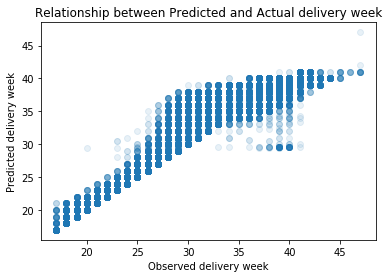

In [37]:
# Plot observed vs predicted values (train set)
plt.scatter(y_train, regr_2.predict(X_train), alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week")

Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week (test set)')

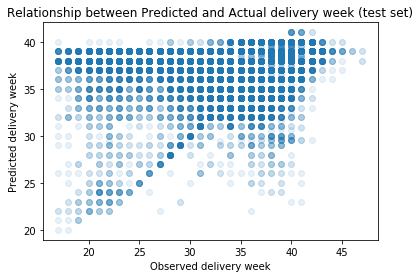

In [38]:
# Plot test set
plt.scatter(y_test, predictions, alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week (test set)")

In [39]:
# R2
R2train = regr_2.score(X_train, y_train)
print('R2train is :', round(R2train, 4))
R2test = regr_2.score(X_test, y_test)
print('R2test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

R2train is : 0.7937
R2test is : 0.0886
Adjusted R2 is : 0.7937


## 5. Boosting - Gradient Boosting ##

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

# Training regressor
gb = GradientBoostingRegressor(random_state=2, n_estimators=10)
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=2, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [41]:
# Make predictions on test data
predictions = gb.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.13 weeks.
Standard deviation of absolute error: 1.6 weeks.
Percent of correct predictions: 32.0 %.
Accuracy: 96.81 %.


Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week')

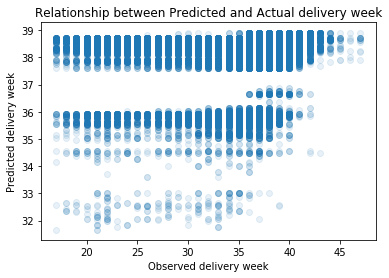

In [42]:
# Plot observed vs predicted values (train set)
plt.scatter(y_train, gb.predict(X_train), alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week")

Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week (test set)')

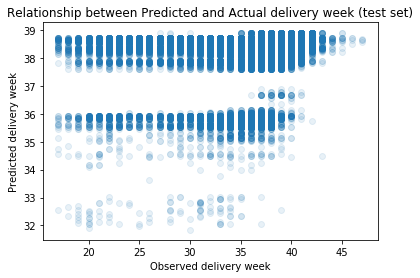

In [43]:
# Plot test set
plt.scatter(y_test, predictions, alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week (test set)")

In [44]:
# R2
R2train = gb.score(X_train, y_train)
print('R2train is :', round(R2train, 4))
R2test = gb.score(X_test, y_test)
print('R2test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

R2train is : 0.0857
R2test is : 0.0871
Adjusted R2 is : 0.0857


In [51]:
# Make predictions on test data
predictions = gb.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.13 weeks.
Standard deviation of absolute error: 1.6 weeks.
Percent of correct predictions: 32.0 %.
Accuracy: 96.81 %.


In [45]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingRegressor

In [46]:
# Training regressor
hgb = HistGradientBoostingRegressor(random_state=2, max_iter=100)
hgb.fit(X_train, y_train)

HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=100, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=2, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)

In [47]:
# Make predictions on test data
predictions = hgb.predict(X_test)
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'weeks.')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'weeks.')
good_pred = errors[errors == 0].count()
print('Percent of correct predictions:', round(good_pred/errors.shape[0], 2)*100,  '%.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.13 weeks.
Standard deviation of absolute error: 1.53 weeks.
Percent of correct predictions: 31.0 %.
Accuracy: 96.83 %.


Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week')

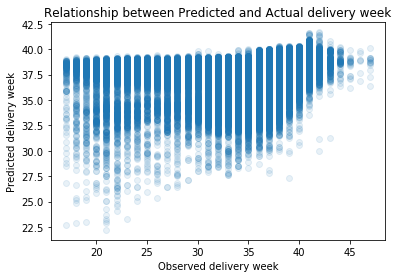

In [48]:
# Plot observed vs predicted values (train set)
plt.scatter(y_train, hgb.predict(X_train), alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week")

Text(0.5, 1.0, 'Relationship between Predicted and Actual delivery week (test set)')

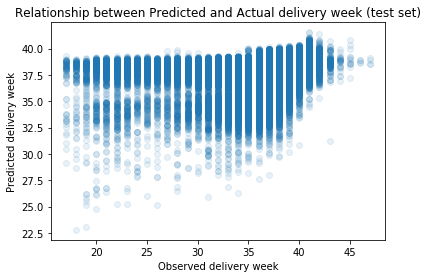

In [49]:
# Plot test set
plt.scatter(y_test, predictions, alpha = 0.1)
plt.xlabel("Observed delivery week")
plt.ylabel("Predicted delivery week")
plt.title("Relationship between Predicted and Actual delivery week (test set)")

In [50]:
# R2
R2train = hgb.score(X_train, y_train)
print('R2train is :', round(R2train, 4))
R2test = hgb.score(X_test, y_test)
print('R2test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

R2train is : 0.1431
R2test is : 0.1394
Adjusted R2 is : 0.143
